In [ ]:
import Pkg

Pkg.add("CSV")
Pkg.add("DataFrames")
Pkg.add("GLMNet")
Pkg.add("GLMakie")
Pkg.add("CairoMakie")
Pkg.add("DecisionTree")
Pkg.add("NearestNeighbors")
Pkg.add("LIBSVM")

In [2]:
using CSV
using DataFrames
using GLMakie
using CairoMakie

using Random
using GLMNet
import DecisionTree
import NearestNeighbors
import LIBSVM
using Statistics: mean, std

## Loading and Cleaning

In [4]:
# Load the dataset
file_path = joinpath(@__DIR__, "../dat/Default.csv")
data = CSV.read(file_path, DataFrame)

# Keep only the relevant columns
columns_to_keep = [:default, :balance, :income]
data = select(data, columns_to_keep)

# Convert 'default' column to numerical (0 for "NO", 1 for "YES")
map_to_Int(s) = s == "No" ? 0 : (s == "Yes" ? 1 : missing)
col = Symbol("default")
transform!(data, col => ByRow(map_to_Int) => col)

describe(data)

3×7 DataFrame
 Row │ variable  mean        min      median     max       nmissing  eltype   
     │ Symbol    Float64     Real     Float64    Real      Int64     DataType 
─────┼────────────────────────────────────────────────────────────────────────
   1 │ default       0.0333    0          0.0        1            0  Int64
   2 │ balance     835.375     0.0      823.637   2654.32         0  Float64
   3 │ income    33517.0     771.968  34552.6    73554.2          0  Float64

## Train Test Split (Ratio, Stratified, Balanced)

In [5]:
function train_test_split(df::DataFrame, ratio::Float64, seed::Real; balanced::Bool = false)
    # Ensure that the ratio is valid
    if ratio <= 0 || ratio >= 1
        error("Ratio must be between 0 and 1.")
    end

    # Set the random seed for reproducibility
    Random.seed!(seed)

    # Group the data by the `default` column
    grouped = groupby(df, :default)

    # Initialize empty DataFrames for train and test sets
    train = DataFrame()
    test = DataFrame()

    
   # If balancing, find the minimum group size
   min_size = Inf64
   if balanced
       min_size = minimum(nrow(g) for g in grouped)
   end

    # Iterate through each group and perform the stratified split
    for g in grouped
        n = nrow(g)

        # Adjust the train size based on balancing
        if balanced
            n = min_size
        end

        train_size = Int(round(ratio * n))
        indices = shuffle(1:n)

        train_indices = indices[1:train_size]
        test_indices = indices[train_size+1:end]

        train = vcat(train, g[train_indices, :])
        test = vcat(test, g[test_indices, :])
    end

    return train, test
end;

In [6]:
train_data_balanced, test_data_balanced = train_test_split(data, 0.8, 420, balanced=true)

len_train_balanced = nrow(train_data_balanced)
len_test_balanced = nrow(test_data_balanced)

println("Balanced:      Train set: $len_train_balanced  | Test set: $len_test_balanced")

train_data, test_data = train_test_split(data, 0.8, 420)

len_train = nrow(train_data)
len_test = nrow(test_data)

println("Stratified:    Train set: $len_train | Test set: $len_test")

Balanced:      Train set: 532  | Test set: 134
Stratified:    Train set: 8000 | Test set: 2000


## Standarization

In [7]:
# Standardize the features
function standardize!(df::DataFrame, cols::Vector{Symbol})
    for col in cols
        df[!, col] = (df[!, col] .- mean(df[!, col])) ./ std(df[!, col])
    end
end

# Standardize train and test data
standardize!(train_data, [:balance, :income])
standardize!(test_data, [:balance, :income])

# Standardize train and test data
standardize!(train_data_balanced, [:balance, :income])
standardize!(test_data_balanced, [:balance, :income])

In [8]:
# Convert the target column to a vector for compatibility
y_train = Float64.(train_data.default)
X_train = Matrix(select(train_data, Not(:default)))

y_test = Float64.(test_data.default)
X_test = Matrix(select(test_data, Not(:default)));

y_train_balanced = Float64.(train_data_balanced.default)
X_train_balanced = Matrix(select(train_data_balanced, Not(:default)))

y_test_balanced = Float64.(test_data_balanced.default)
X_test_balanced = Matrix(select(test_data_balanced, Not(:default)));

## Confusion Matrix

In [9]:
function compute_confusion_matrix(y_true::Vector{Float64}, y_pred::Vector{Float64})
    tp = sum((y_true .== 1.0) .& (y_pred .== 1.0))  # True Positives
    tn = sum((y_true .== 0.0) .& (y_pred .== 0.0))  # True Negatives
    fp = sum((y_true .== 0.0) .& (y_pred .== 1.0))  # False Positives
    fn = sum((y_true .== 1.0) .& (y_pred .== 0.0))  # False Negatives
    return [tp fp; fn tn]
end


function plot_confusion_matrix(conf_matrix; title::String="Confusion Matrix")
    fig = Figure(size=(800,600))
    ax = Axis(fig[1, 1], title=title)
    heatmap!(
        ax, 
        conf_matrix, 
        colormap=:vanimo)
        # colormap=:buda)

    # Add annotations for counts and names
    names = ["True Pos", "False Pos", "False Neg", "True Neg"]
    positions = [(1, 1), (1, 2), (2, 1), (2, 2)]  # Row, Column positions in the matrix

    for (idx, (row, col)) in enumerate(positions)
        count = conf_matrix[row, col]
        name = names[idx]
        
        # Add the text annotation
        text!(
            ax,
            Point(col, row),  # Position centered in each heatmap cell
            text="$name: $count",  # Combine name and count
            align=(:center, :center),
            color=:black,
            fontsize=25    
        )
    end    
    
    return fig
end;

## ROC Curve

In [10]:
function calculate_roc_curve(y_true::Vector{Float64}, y_probs::Vector{Float64})
    # Check input dimensions
    if length(y_true) != length(y_probs)
        throw(ArgumentError("y_true and y_probs must have the same length"))
    end

    # Validate that y_true contains only 0.0 and 1.0
    if any(y_true .!= 0.0 .&& y_true .!= 1.0)
        throw(ArgumentError("y_true must contain only 0.0 and 1.0"))
    end

    # Sort by predicted probabilities in descending order
    data = DataFrame(y_true = y_true, y_probs = y_probs)
    sort!(data, :y_probs, rev=true)

    # Initialize variables
    thresholds = unique(data.y_probs)  # Use unique predicted probabilities as thresholds
    tpr = Float64[]  # True Positive Rate
    fpr = Float64[]  # False Positive Rate

    for threshold in thresholds
        # Get predicted labels based on the threshold
        y_pred = data.y_probs .>= threshold

        # Calculate confusion matrix components
        tp = sum(y_pred .&& (data.y_true .== 1.0))
        fp = sum(y_pred .&& (data.y_true .== 0.0))
        fn = sum(.!y_pred .&& (data.y_true .== 1.0))
        tn = sum(.!y_pred .&& (data.y_true .== 0.0))

        # Compute TPR and FPR
        push!(tpr, tp / (tp + fn))
        push!(fpr, fp / (fp + tn))
    end

    return fpr, tpr, thresholds
end;

In [11]:
function plot_roc_curve(y_true::Vector{Float64}, y_prob::Vector{Float64}; title::String="ROC Curve")
    # Ensure inputs are valid
    if length(y_true) != length(y_pred)
        error("y_true and y_pred must have the same length.")
    end

    fpr, tpr, thresholds = calculate_roc_curve(y_true, y_prob)

    # Calculate AUC using the trapezoidal rule
    auc = 0.0
    for i in 2:length(fpr)
        auc += (fpr[i] - fpr[i-1]) * (tpr[i] + tpr[i-1]) / 2
    end

    # Plot ROC Curve 
    fig = Figure(size=(800, 600))
    ax = Axis(fig[1, 1], 
        xlabel="False Positive Rate (FPR)", 
        ylabel="True Positive Rate (TPR)", 
        title=title)
    
    # Plot ROC Curve
    lines!(ax, fpr, tpr, label="ROC Curve", color=:blue, linewidth=2)
    scatter!(ax, fpr, tpr, color=:red, markersize=5)
    
    # Plot random guess line
    lines!(ax, [0, 1], [0, 1], linestyle=:dash, color=:gray, label="Random Guess")
    
    # Add AUC annotation
    text!(
            ax,
            Point(0.7, 0.1),
            text="AUC = $(round(auc, digits=4))",
            align=(:center, :center),
            color=:black,
            fontsize=16    
        )
    
    # Add legend
    Legend(fig[1, 2], ax, orientation=:vertical)
    
    return fig
end;

## LASSO

### Stratified

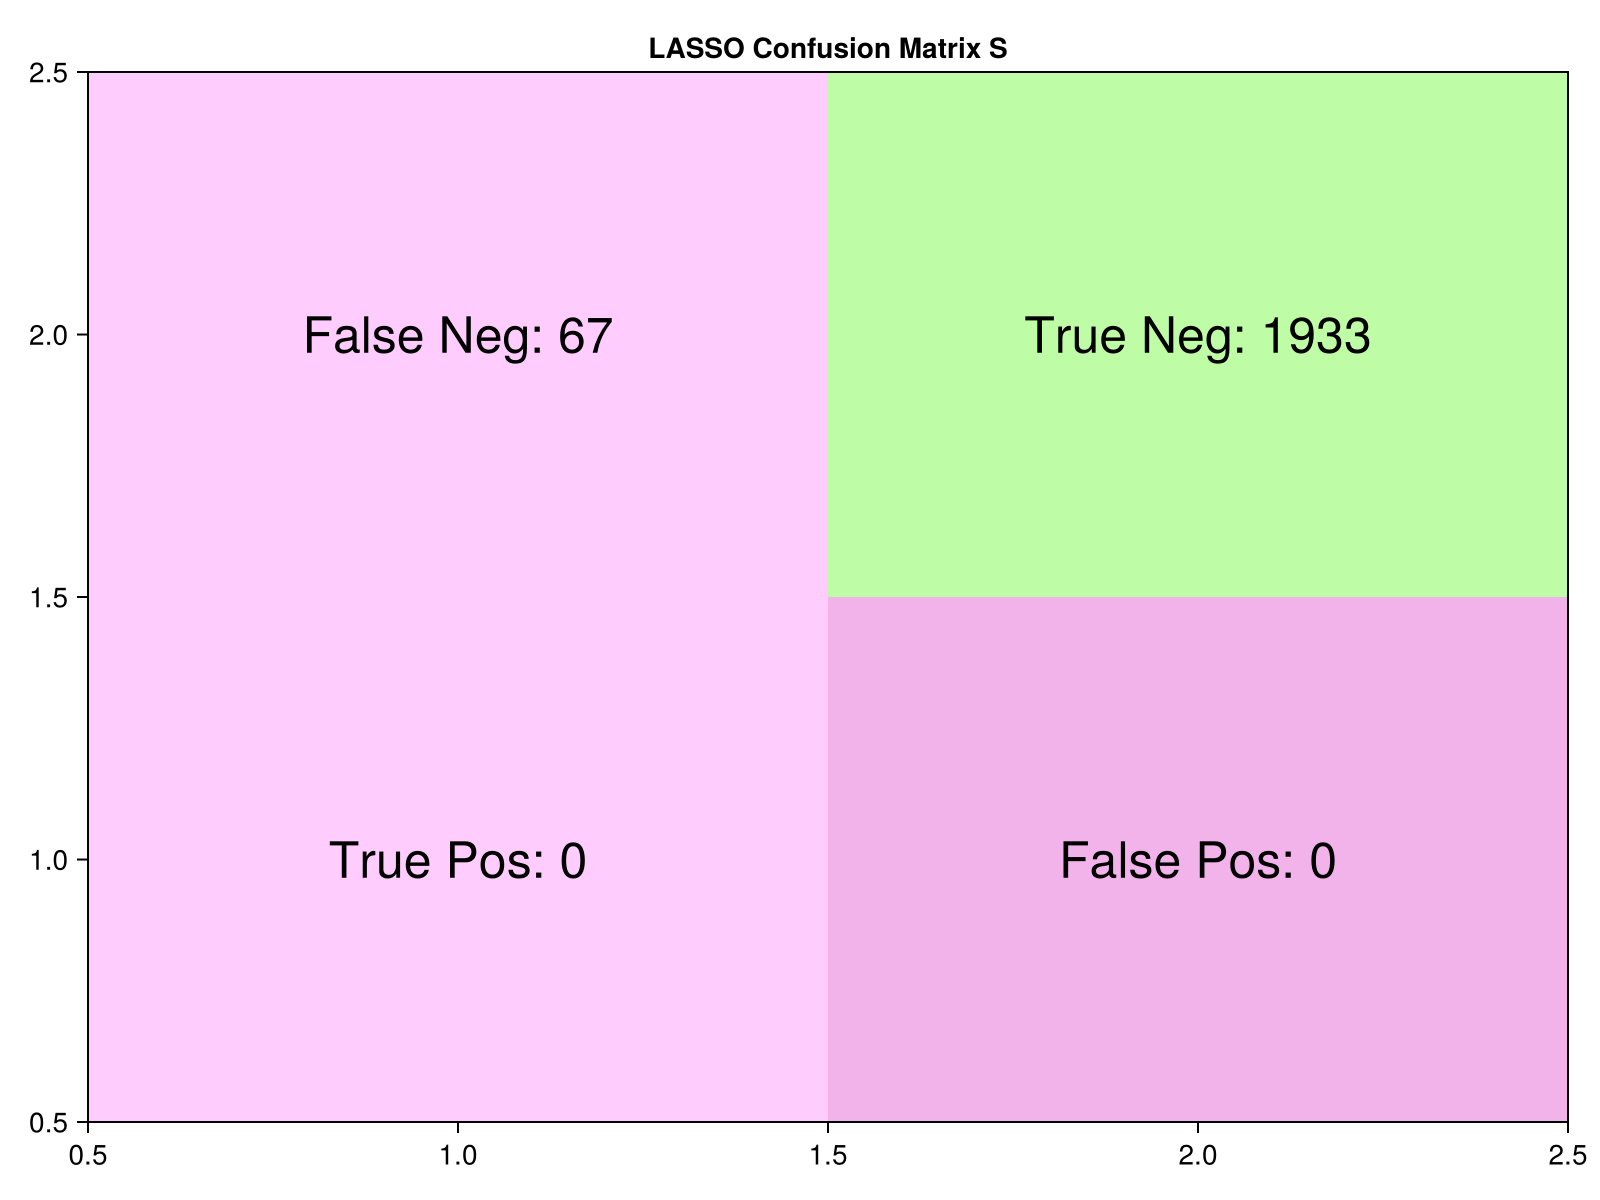

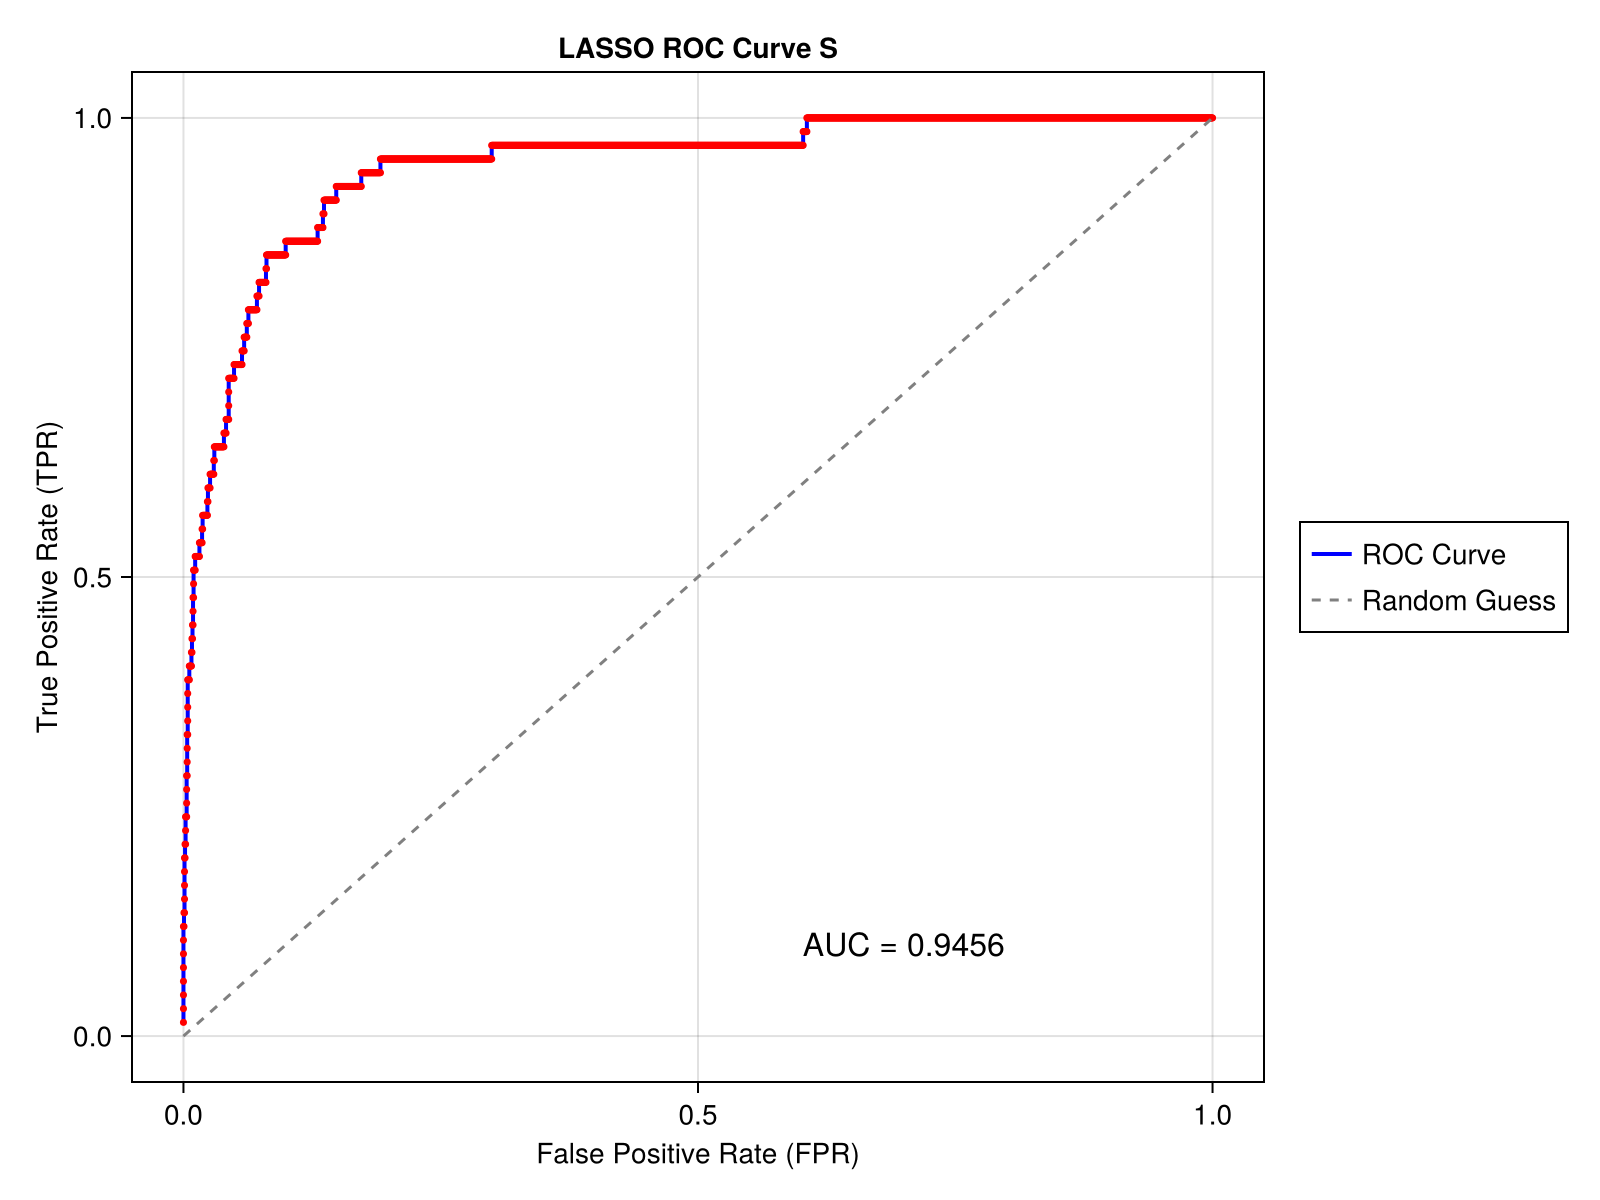

In [12]:
# Train LASSO Classification Model using Cross-Validation
lasso_cv_model = glmnetcv(X_train, y_train; alpha=1.0)

# Predict probabilities on the test set 
pred_probs = predict(lasso_cv_model, X_test)

# Threshold probabilities to get binary predictions
threshold = 0.5
predictions = pred_probs .>= threshold
y_pred = Float64.(predictions)

# Evaluate the confusion matrix
conf_matrix = compute_confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
conf_matrix_fig = plot_confusion_matrix(conf_matrix, title="LASSO Confusion Matrix S")
display(conf_matrix_fig)

save_path = joinpath(@__DIR__, "../fig/LASSO_CM_S.png")
save(save_path, conf_matrix_fig)  # Save as PNG

# Plot the ROC curve
fig = plot_roc_curve(y_test, pred_probs, title="LASSO ROC Curve S")
display(fig)

save_path = joinpath(@__DIR__, "../fig/LASSO_ROC_S.png")
save(save_path, fig);  # Save as PNG

### Balanced

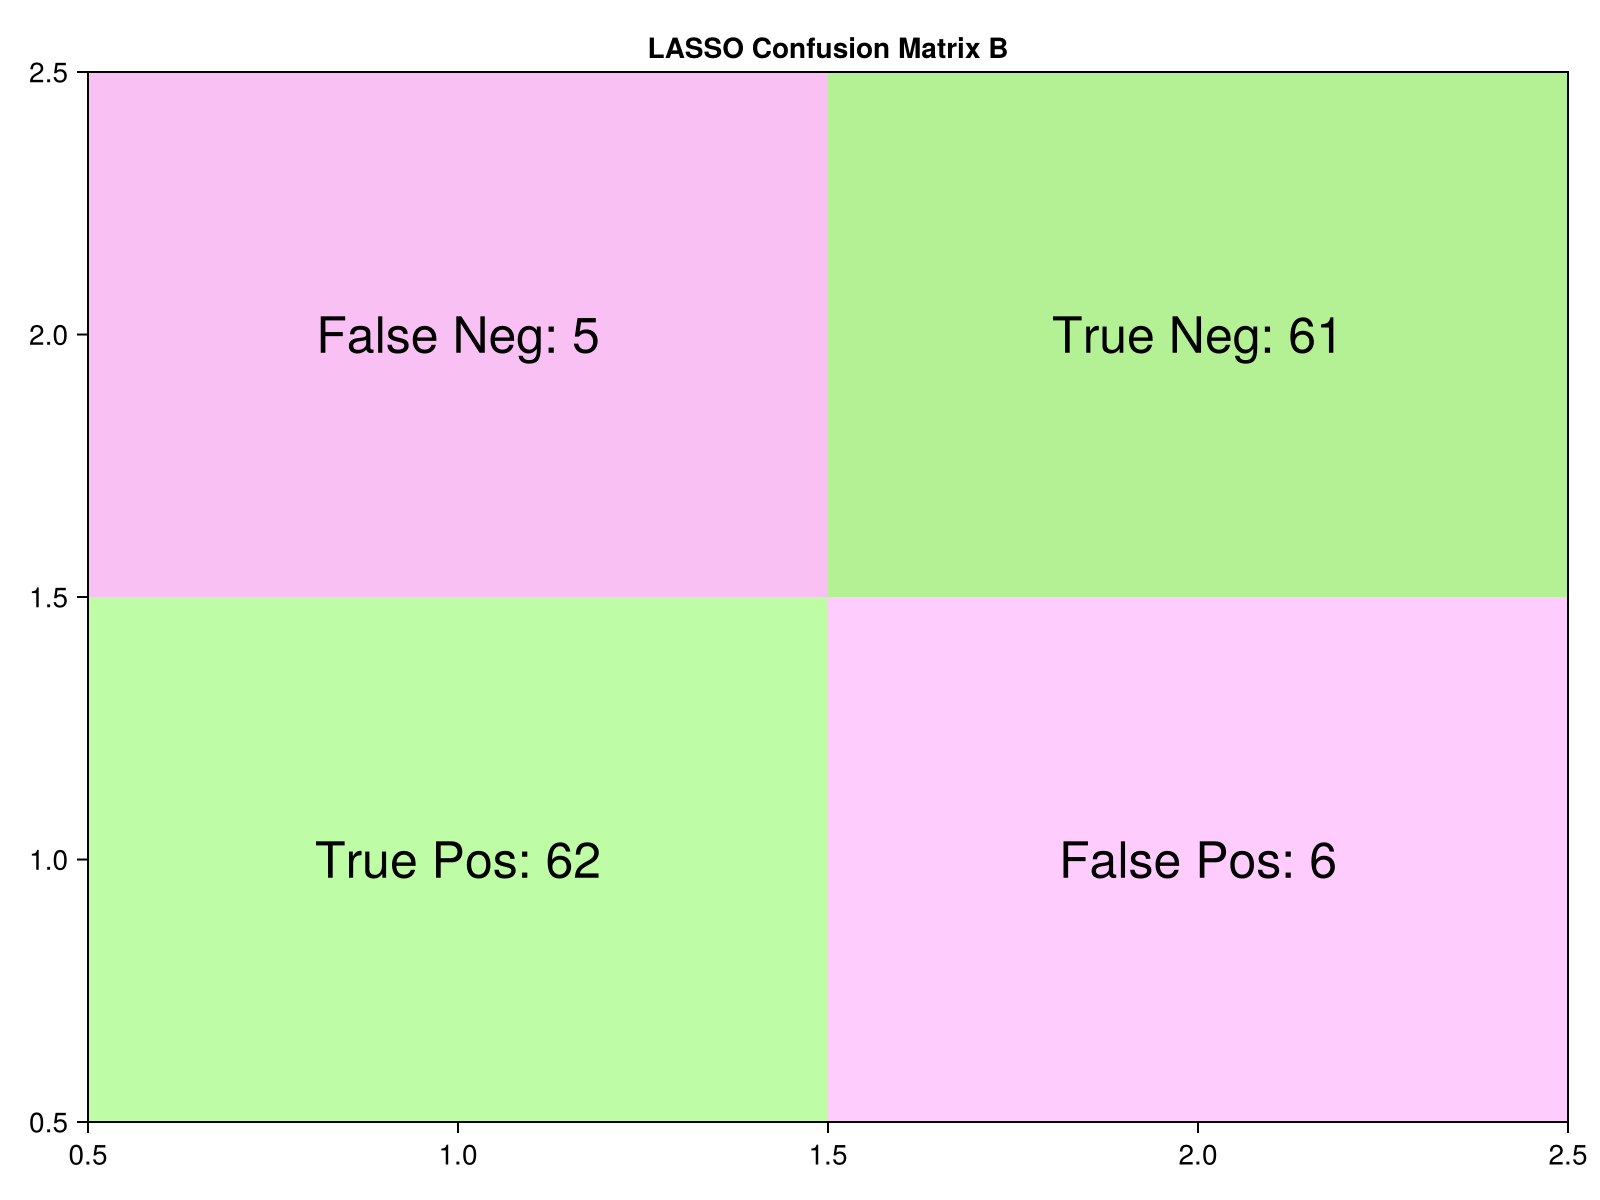

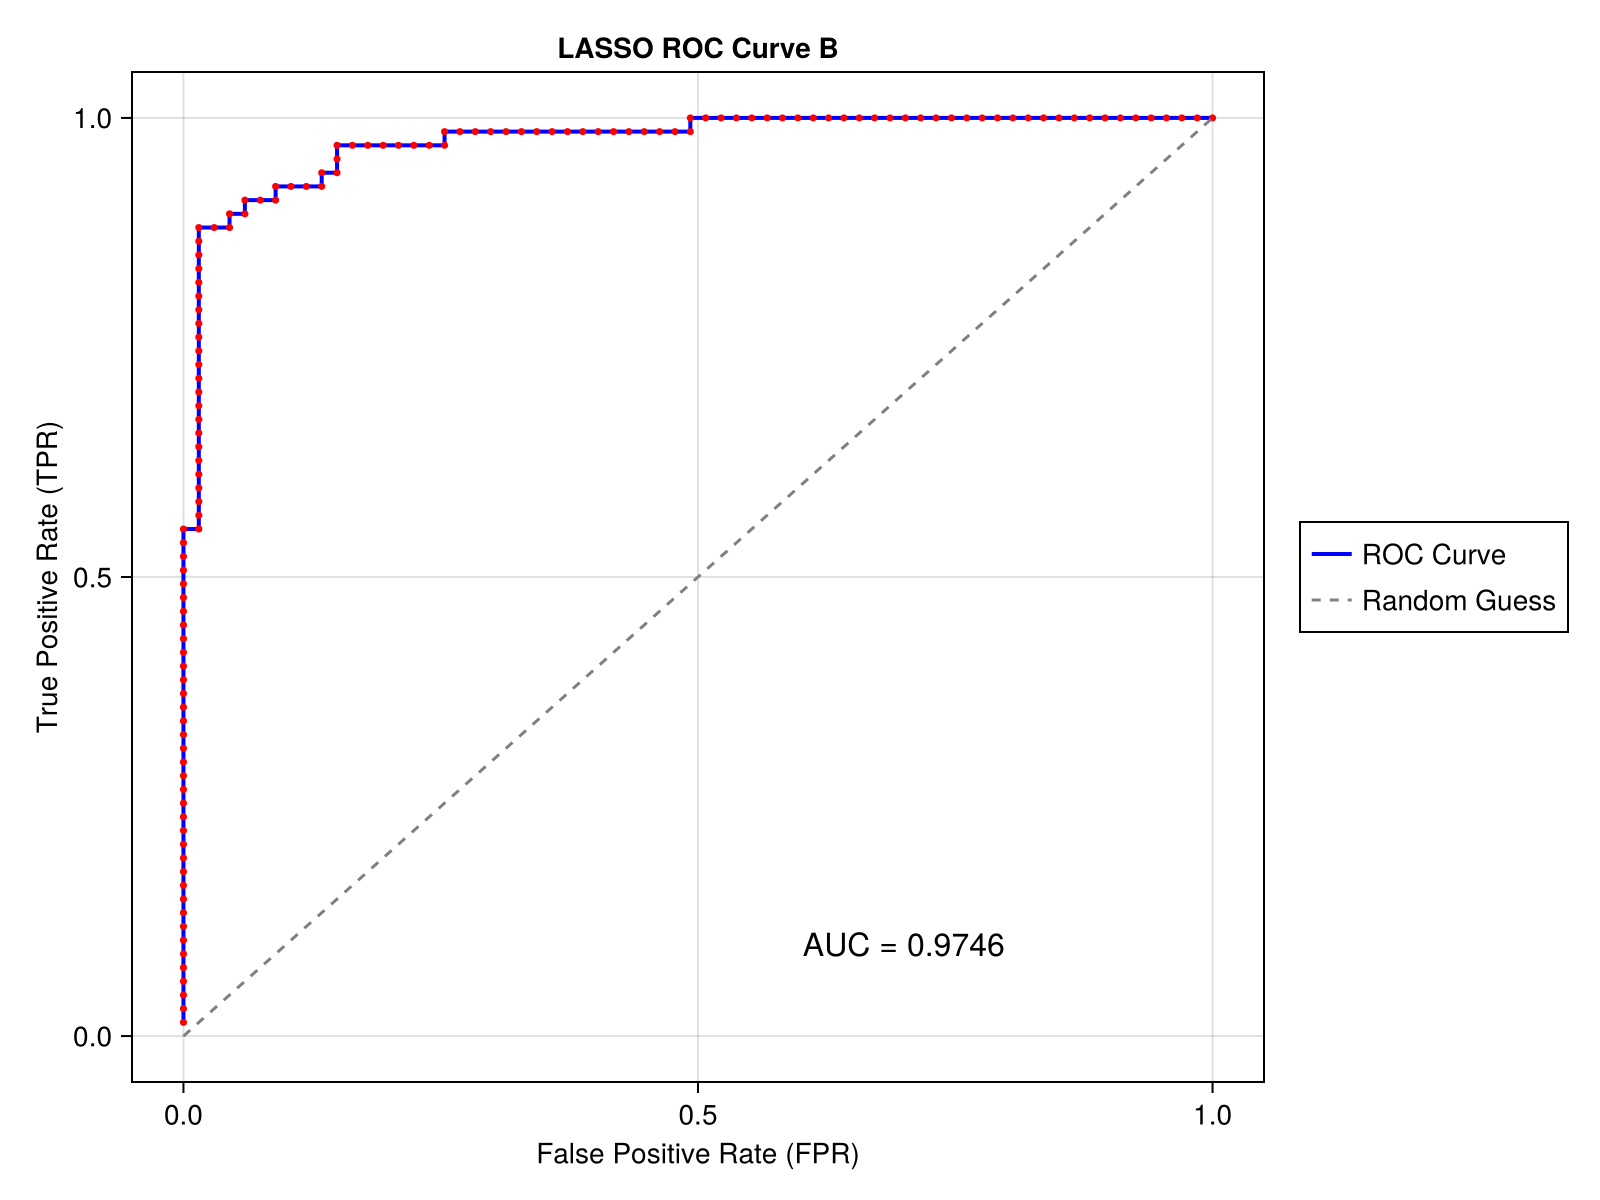

In [13]:
# Use cross-validation to select the best lambda
lasso_cv_model = glmnetcv(X_train_balanced, y_train_balanced; alpha=0.0)

# Predict probabilities on the test set using the best lambda
pred_probs = predict(lasso_cv_model, X_test_balanced)

# Threshold probabilities to get binary predictions
threshold = 0.5
predictions = pred_probs .>= threshold
y_pred = Float64.(predictions)

# Evaluate the confusion matrix
conf_matrix = compute_confusion_matrix(y_test_balanced, y_pred)

# Plot the confusion matrix
conf_matrix_fig = plot_confusion_matrix(conf_matrix, title="LASSO Confusion Matrix B")
display(conf_matrix_fig)

save_path = joinpath(@__DIR__, "../fig/LASSO_CM_B.png")
save(save_path, conf_matrix_fig)  # Save as PNG

# Plot the ROC curve
fig = plot_roc_curve(y_test_balanced, pred_probs, title="LASSO ROC Curve B")
display(fig)

save_path = joinpath(@__DIR__, "../fig/LASSO_ROC_B.png")
save(save_path, fig);  # Save as PNG

## Ridge

### Stratified

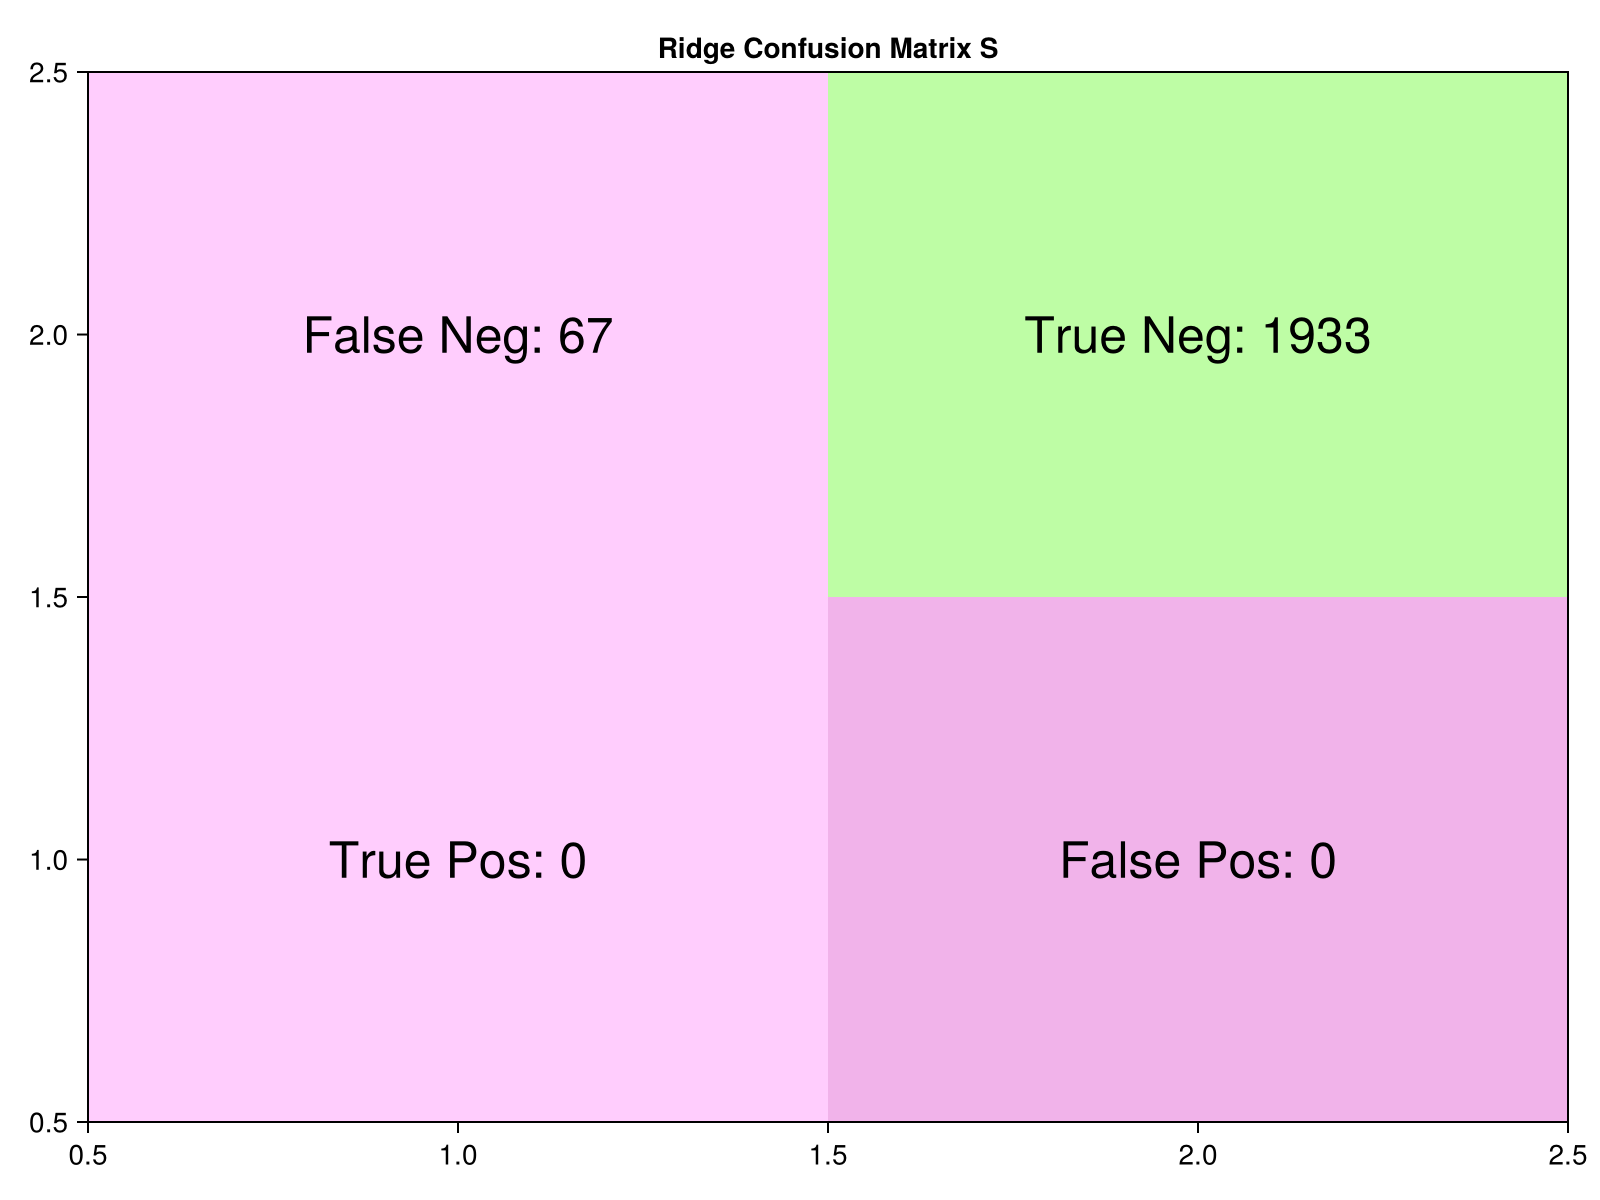

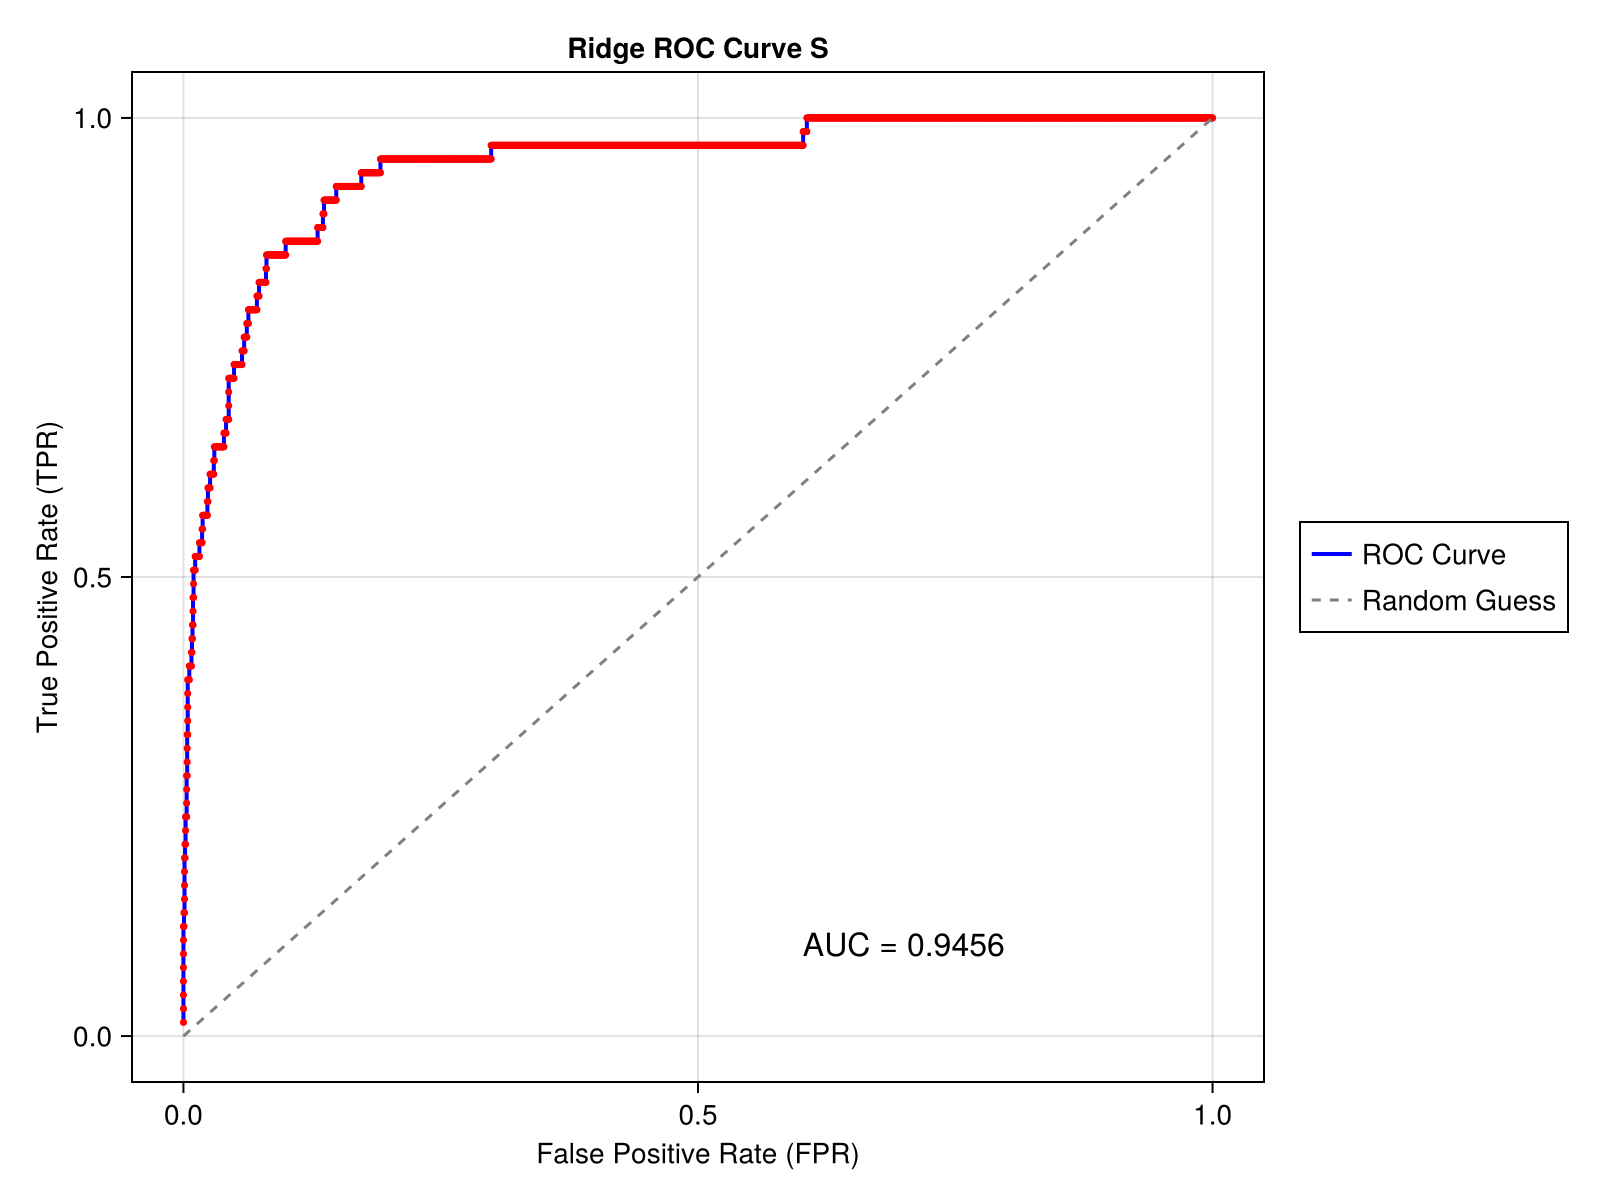

In [14]:
# Train Ridge Classification Model using Cross-Validation
ridge_cv_model = glmnetcv(X_train, y_train; alpha=0.0)

# Predict Probabilities on the test set
pred_probs = predict(ridge_cv_model, X_test)

# Threshold probabilities to get binary predictions
threshold = 0.5
predictions = pred_probs .>= threshold
y_pred = Float64.(predictions)

# Evaluate the confusion matrix
conf_matrix = compute_confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
conf_matrix_fig = plot_confusion_matrix(conf_matrix, title="Ridge Confusion Matrix S")
display(conf_matrix_fig)

save_path = joinpath(@__DIR__, "../fig/Ridge_CM_S.png")
save(save_path, conf_matrix_fig)  # Save as PNG

# Plot the ROC curve
fig = plot_roc_curve(y_test, pred_probs, title="Ridge ROC Curve S")
display(fig)

save_path = joinpath(@__DIR__, "../fig/Ridge_ROC_S.png")
save(save_path, fig);  # Save as PNG

### Balanced

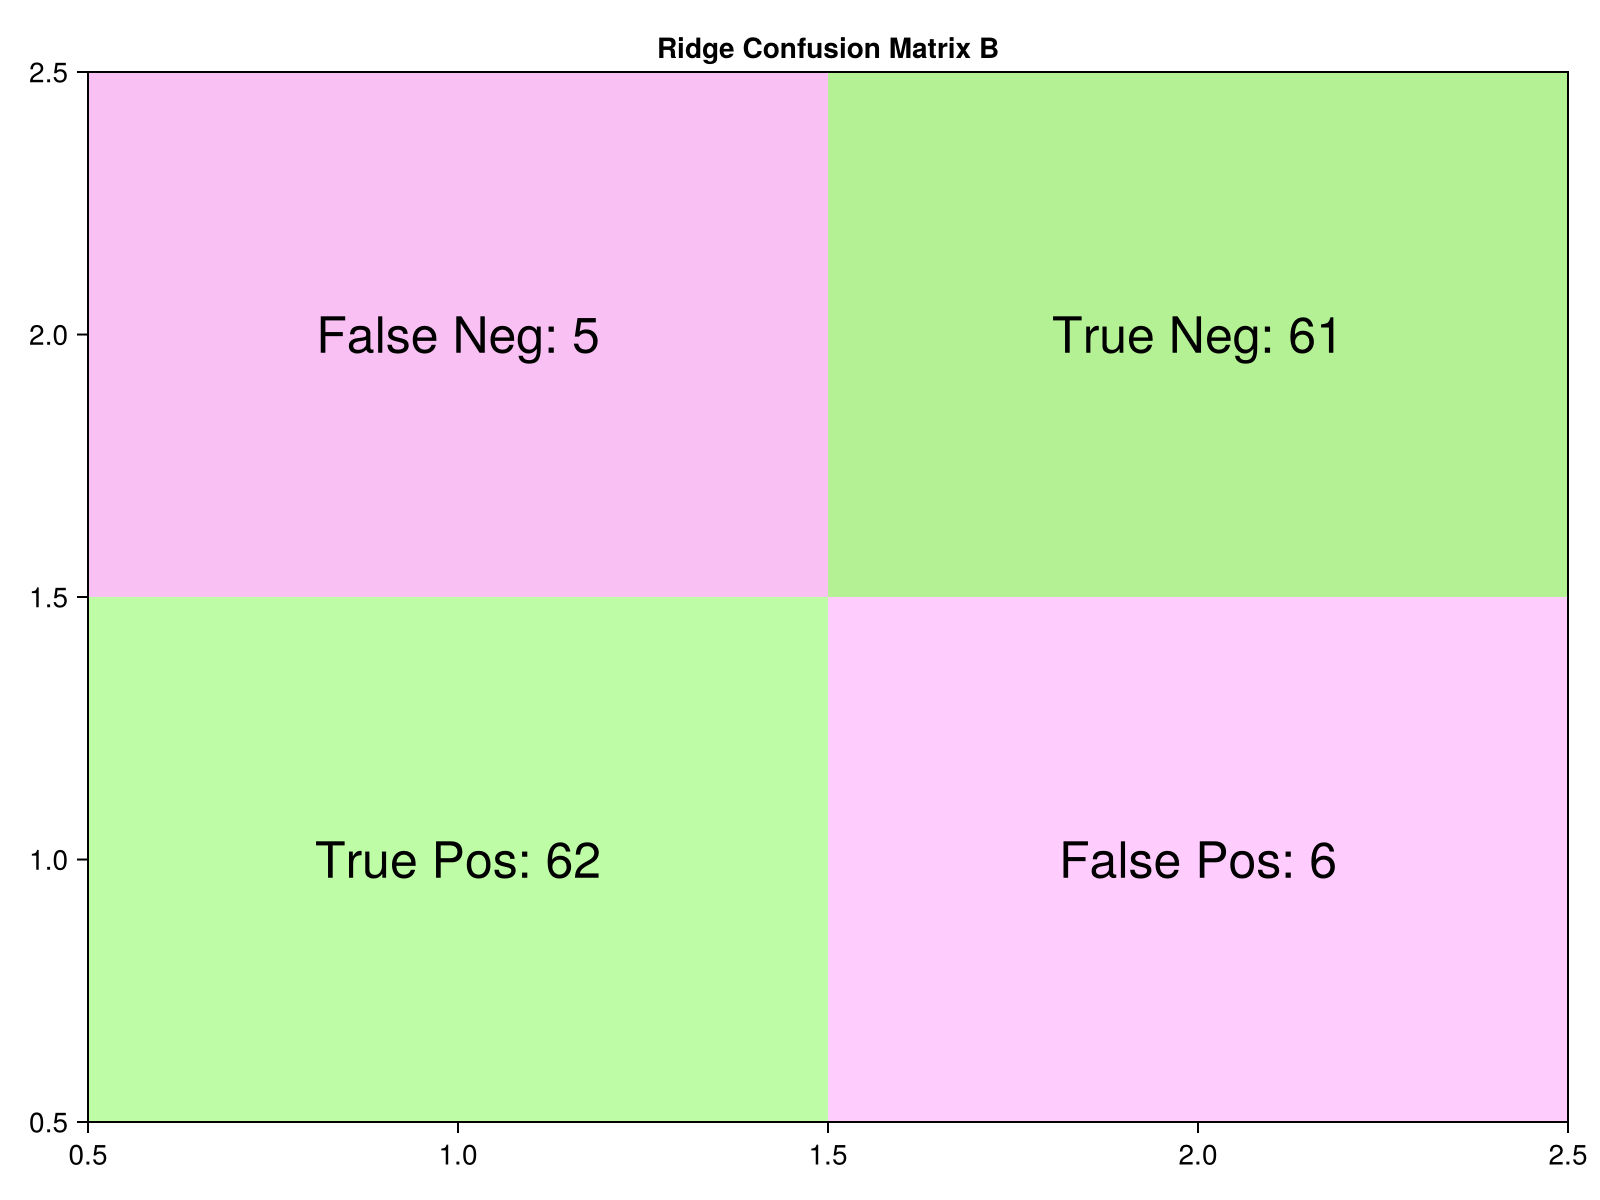

In [15]:
# Train Ridge Classification Model using Cross-Validation
ridge_cv_model = glmnetcv(X_train_balanced, y_train_balanced; alpha=0.0)

# Predict Probabilities on the test set
pred_probs = predict(ridge_cv_model, X_test_balanced)

# Threshold probabilities to get binary predictions
threshold = 0.5
predictions = pred_probs .>= threshold
y_pred = Float64.(predictions)

# Evaluate the confusion matrix
conf_matrix = compute_confusion_matrix(y_test_balanced, y_pred)

# Plot the confusion matrix
conf_matrix_fig = plot_confusion_matrix(conf_matrix, title="Ridge Confusion Matrix B")
display(conf_matrix_fig)

save_path = joinpath(@__DIR__, "../fig/Ridge_CM_B.png")
save(save_path, conf_matrix_fig)  # Save as PNG

# Plot the ROC curve
fig = plot_roc_curve(y_test_balanced, pred_probs, title="Ridge ROC Curve B")
display(fig)

save_path = joinpath(@__DIR__, "../fig/Ridge_ROC_B.png")
save(save_path, fig);  # Save as PNG

## Elastic Net

### Stratified

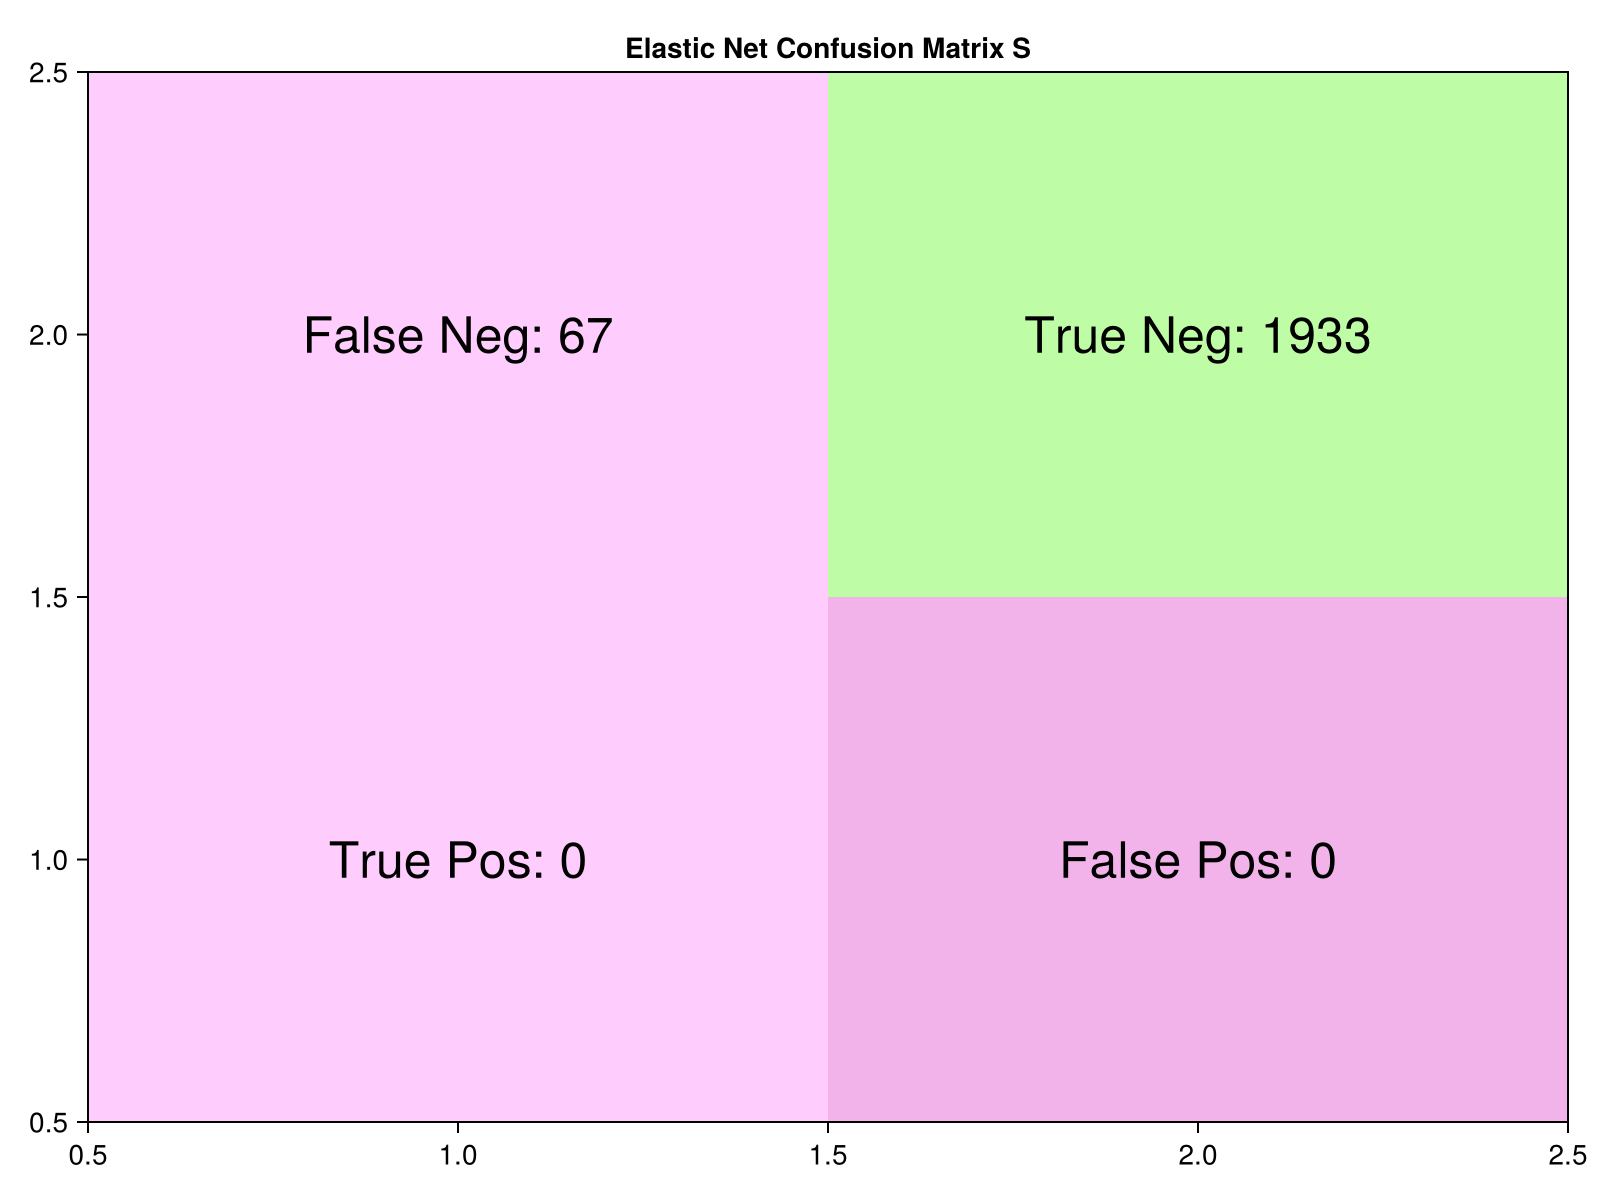

In [16]:
# Train Elastic Net Classification Model using Cross-Validation
elasticnet_cv_model = glmnetcv(X_train, y_train; alpha=0.5)

# Predict Probabilities on the test set
pred_probs = predict(elasticnet_cv_model, X_test)

# Threshold probabilities to get binary predictions
threshold = 0.5
predictions = pred_probs .>= threshold
y_pred = Float64.(predictions)

# Evaluate the confusion matrix
conf_matrix = compute_confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
conf_matrix_fig = plot_confusion_matrix(conf_matrix, title="Elastic Net Confusion Matrix S")
display(conf_matrix_fig)

save_path = joinpath(@__DIR__, "../fig/ElasticNet_CM_S.png")
save(save_path, conf_matrix_fig)  # Save as PNG

# Plot the ROC curve
fig = plot_roc_curve(y_test, pred_probs, title="Elastic Net ROC Curve S")
display(fig)

save_path = joinpath(@__DIR__, "../fig/ElasticNet_ROC_S.png")
save(save_path, fig);  # Save as PNG

### Balanced

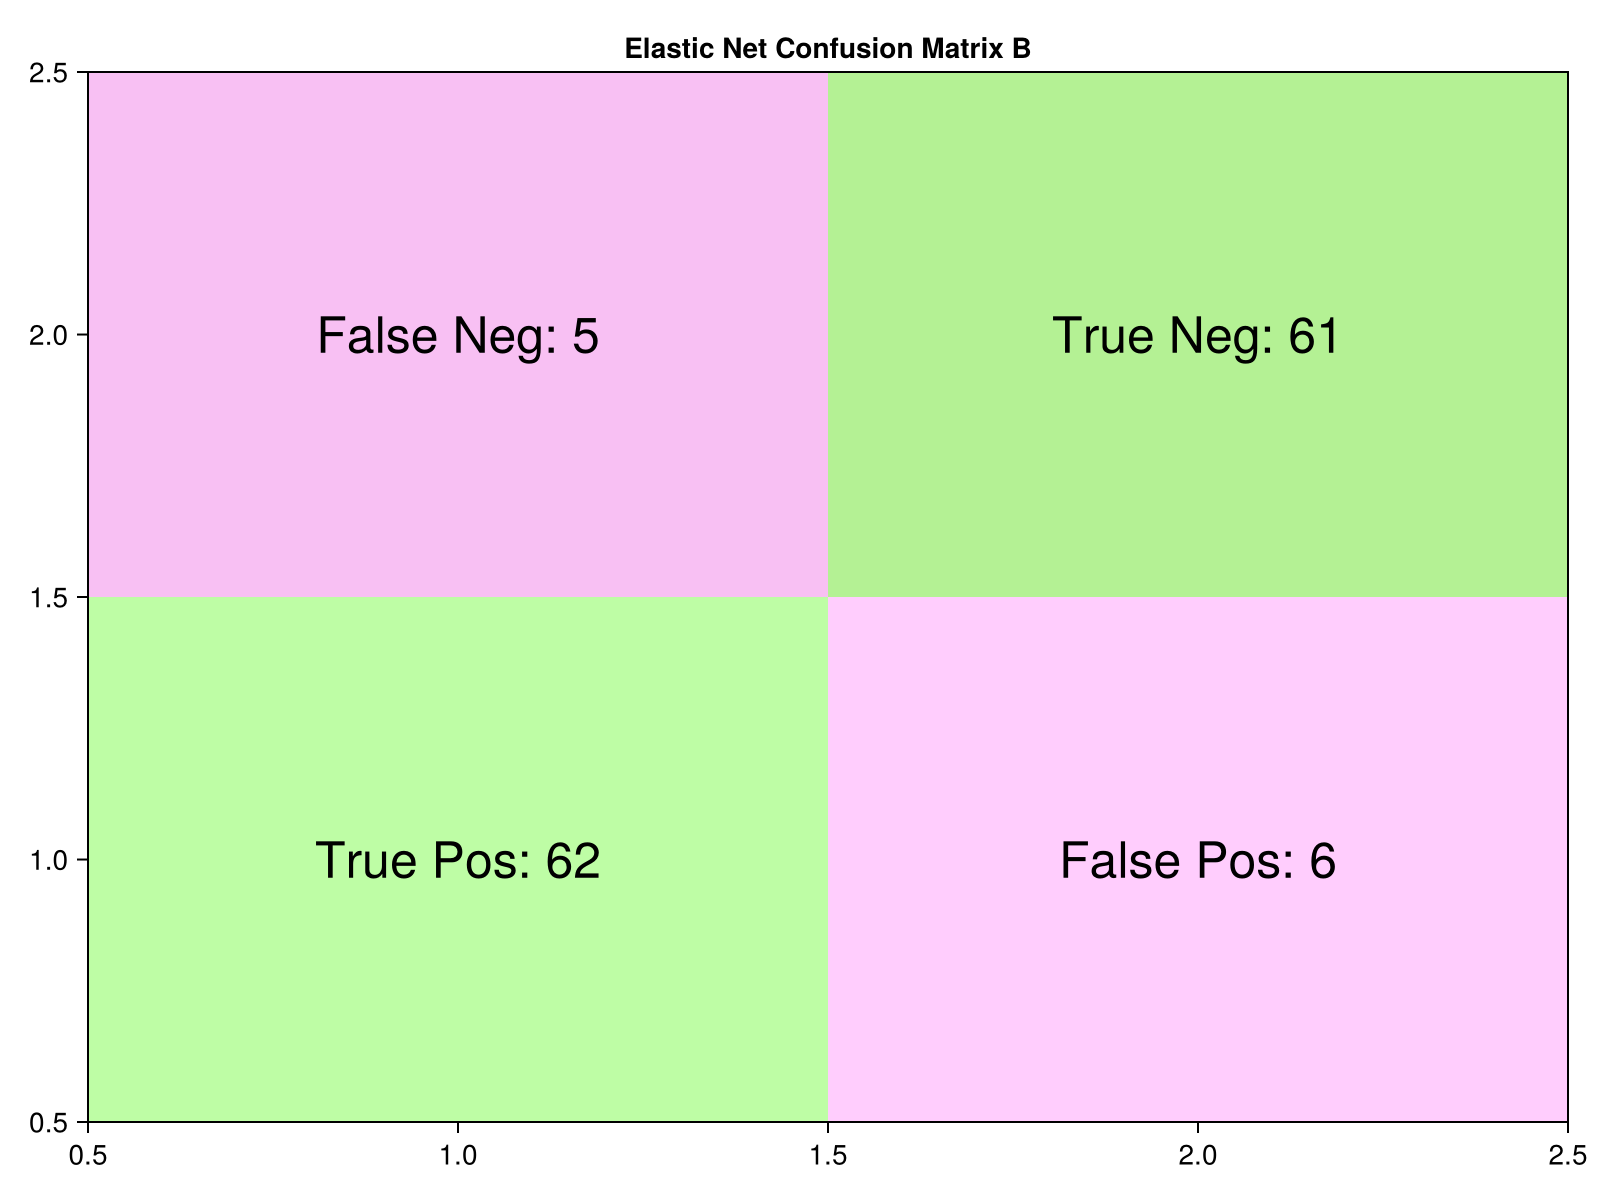

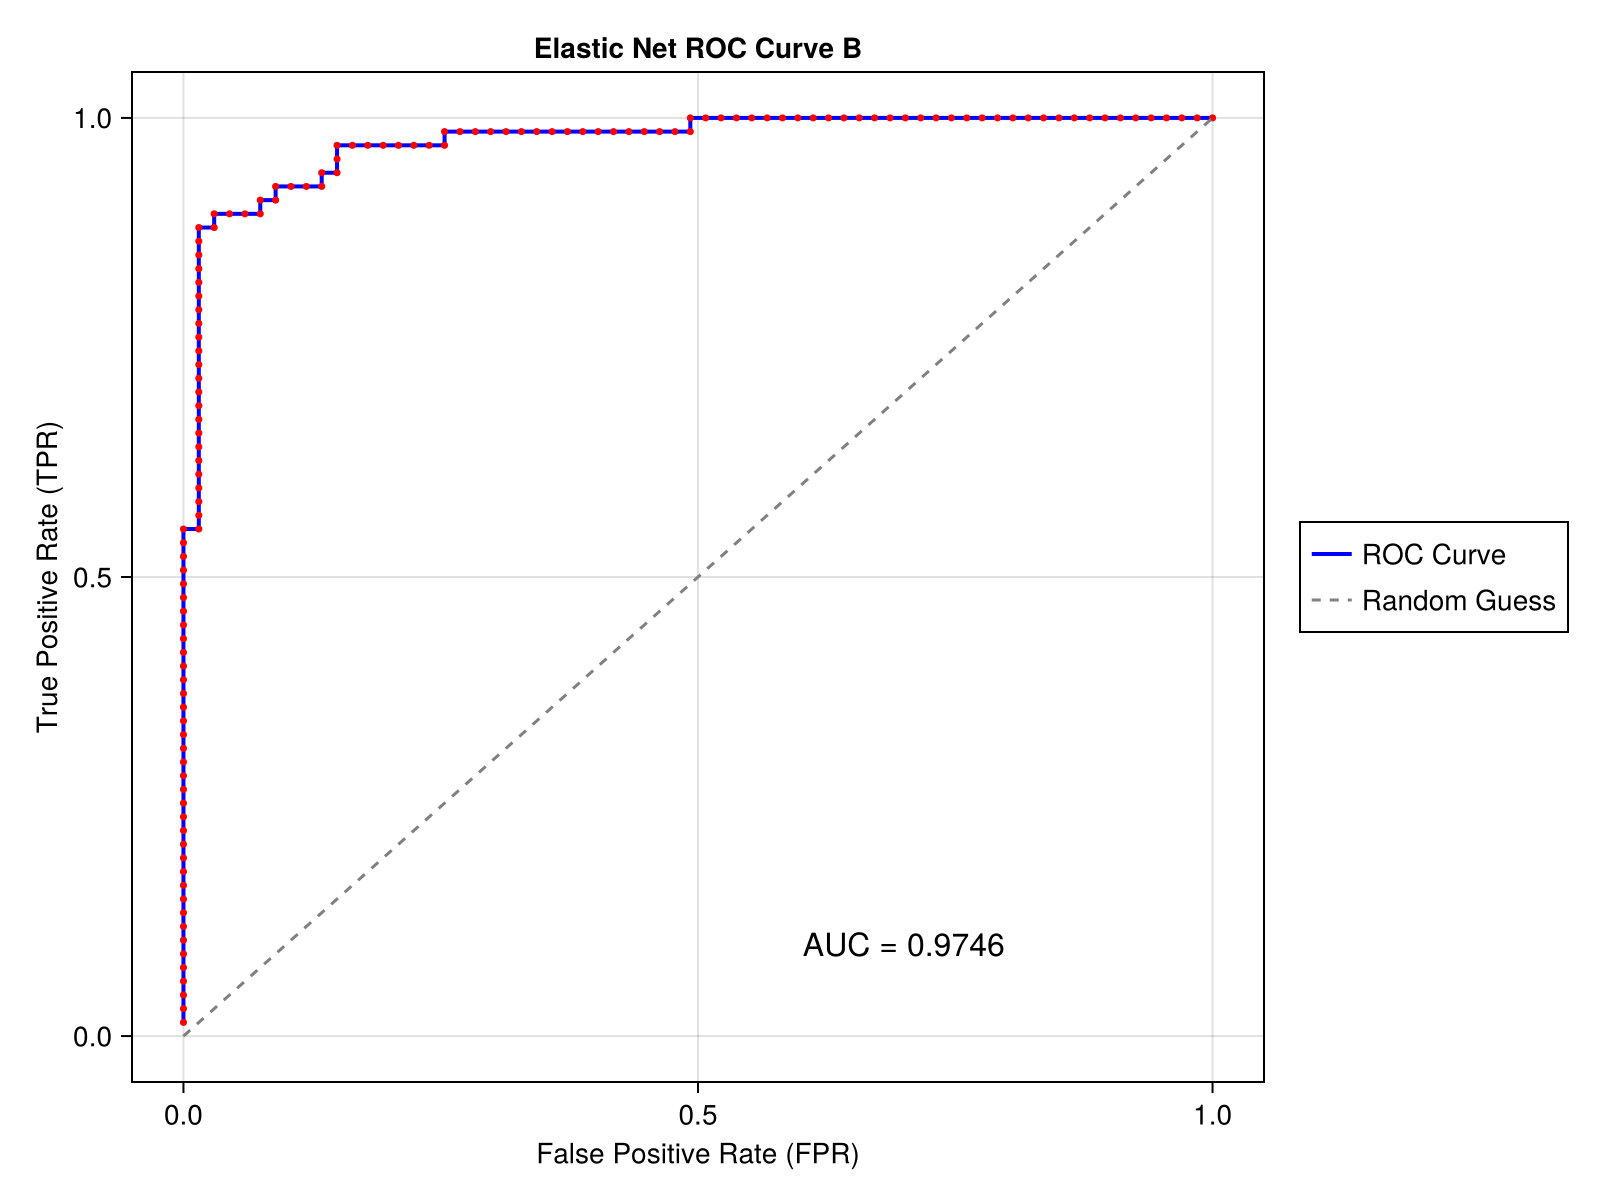

In [17]:
# Train Elastic Net Classification Model using Cross-Validation
elasticnet_cv_model = glmnetcv(X_train_balanced, y_train_balanced; alpha=0.5)

# Predict Probabilities on the test set
pred_probs = predict(elasticnet_cv_model, X_test_balanced)

# Threshold probabilities to get binary predictions
threshold = 0.5
predictions = pred_probs .>= threshold
y_pred = Float64.(predictions)

# Evaluate the confusion matrix
conf_matrix = compute_confusion_matrix(y_test_balanced, y_pred)

# Plot the confusion matrix
conf_matrix_fig = plot_confusion_matrix(conf_matrix, title="Elastic Net Confusion Matrix B")
display(conf_matrix_fig)

save_path = joinpath(@__DIR__, "../fig/ElasticNet_CM_B.png")
save(save_path, conf_matrix_fig)  # Save as PNG

# Plot the ROC curve
fig = plot_roc_curve(y_test_balanced, pred_probs, title="Elastic Net ROC Curve B")
display(fig)

save_path = joinpath(@__DIR__, "../fig/ElasticNet_ROC_B.png")
save(save_path, fig);  # Save as PNG

## Decision Tree

### Stratified

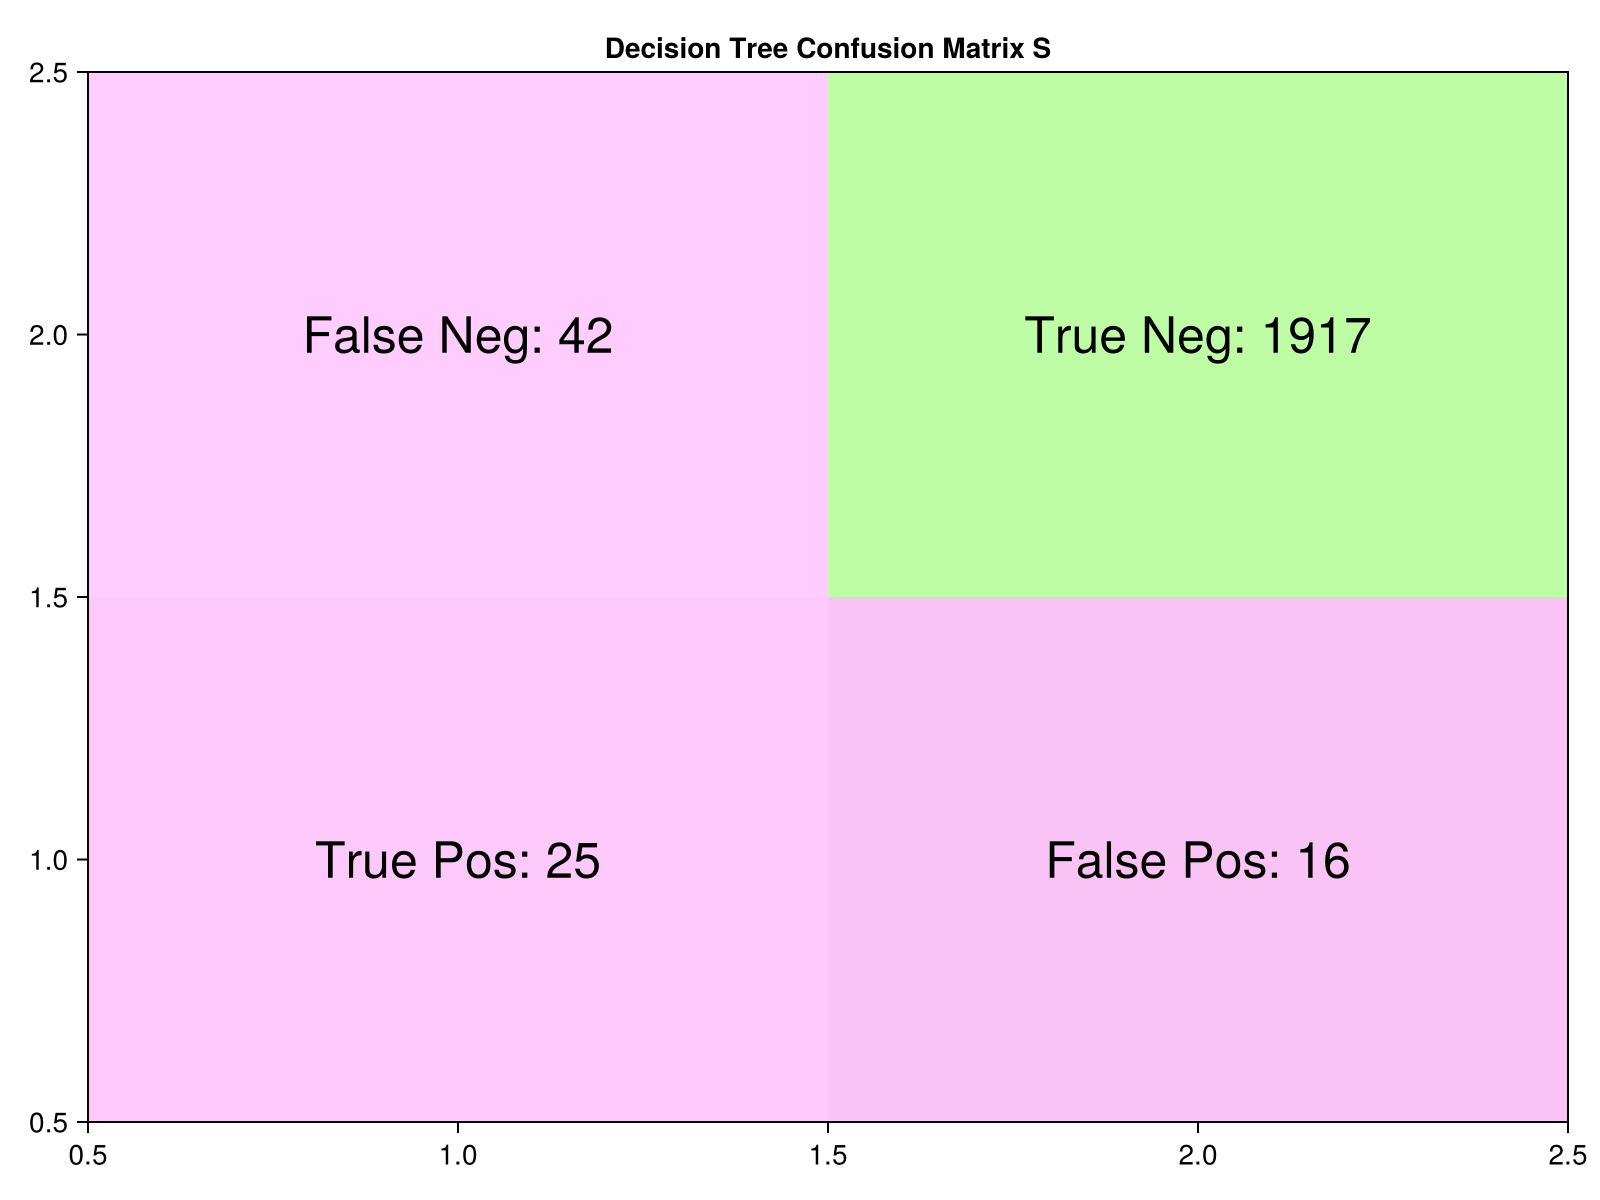

In [18]:
# Train Decision Tree Classification Model
dt_model = DecisionTree.DecisionTreeClassifier(max_depth=5, min_samples_split=10)
DecisionTree.fit!(dt_model, X_train, y_train)

# Predict Probabilities on the test set
pred_probs = DecisionTree.predict(dt_model, X_test)

# Threshold probabilities to get binary predictions
threshold = 0.5
predictions = pred_probs .>= threshold
y_pred = Float64.(predictions)

# Evaluate the confusion matrix
conf_matrix = compute_confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
conf_matrix_fig = plot_confusion_matrix(conf_matrix, title="Decision Tree Confusion Matrix S")
display(conf_matrix_fig)

save_path = joinpath(@__DIR__, "../fig/DecisionTree_CM_S.png")
save(save_path, conf_matrix_fig)  # Save as PNG

# Plot the ROC curve
fig = plot_roc_curve(y_test, pred_probs, title="Decision Tree ROC Curve S")
display(fig)

save_path = joinpath(@__DIR__, "../fig/DecisionTree_ROC_S.png")
save(save_path, fig);  # Save as PNG

### Balanced

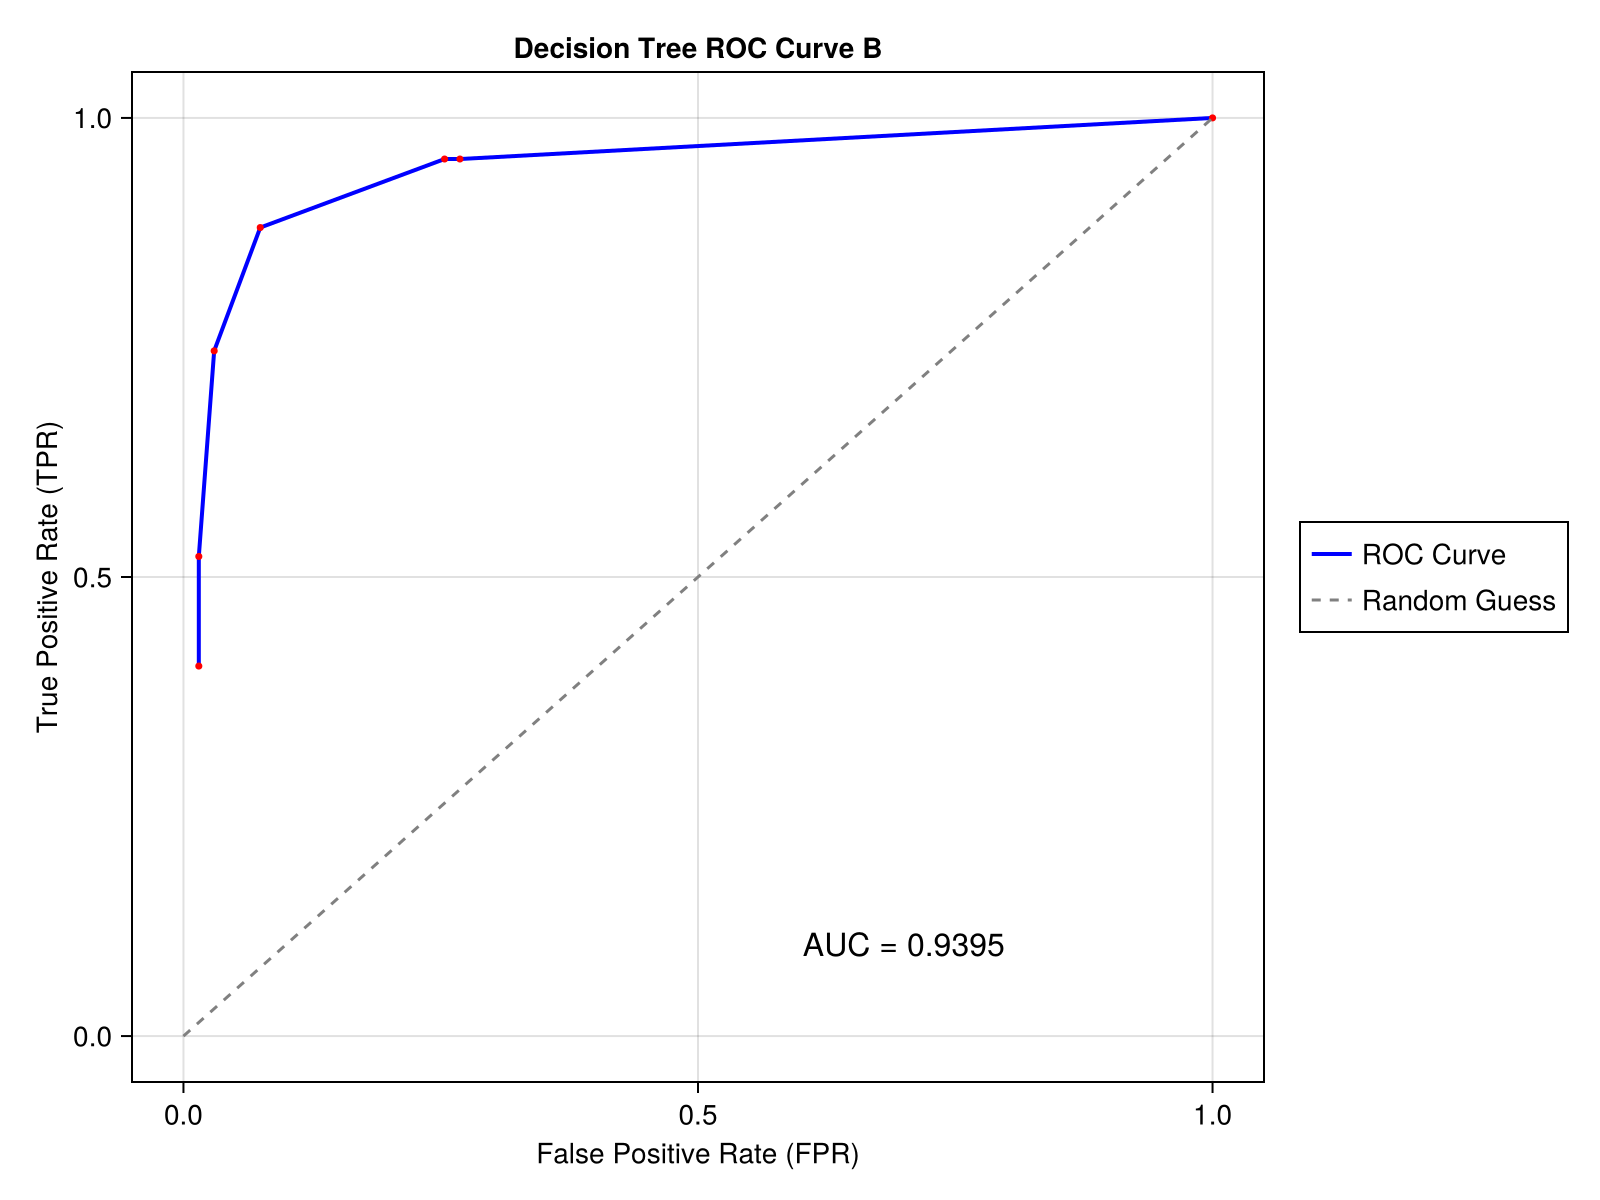

In [19]:
# Train Decision Tree Classification Model
dt_model = DecisionTree.DecisionTreeClassifier(max_depth=5, min_samples_split=10)
DecisionTree.fit!(dt_model, X_train_balanced, y_train_balanced)

# Predict Probabilities on the test set
pred_probs = DecisionTree.predict(dt_model, X_test_balanced)

# Threshold probabilities to get binary predictions
threshold = 0.5
predictions = pred_probs .>= threshold
y_pred = Float64.(predictions)

# Evaluate the confusion matrix
conf_matrix = compute_confusion_matrix(y_test_balanced, y_pred)

# Plot the confusion matrix
conf_matrix_fig = plot_confusion_matrix(conf_matrix, title="Decision Tree Confusion Matrix B")
display(conf_matrix_fig)

save_path = joinpath(@__DIR__, "../fig/DecisionTree_CM_B.png")
save(save_path, conf_matrix_fig)  # Save as PNG

# Plot the ROC curve
fig = plot_roc_curve(y_test_balanced, pred_probs, title="Decision Tree ROC Curve B")
display(fig)

save_path = joinpath(@__DIR__, "../fig/DecisionTree_ROC_B.png")
save(save_path, fig);  # Save as PNG

## Random Forest

### Stratified

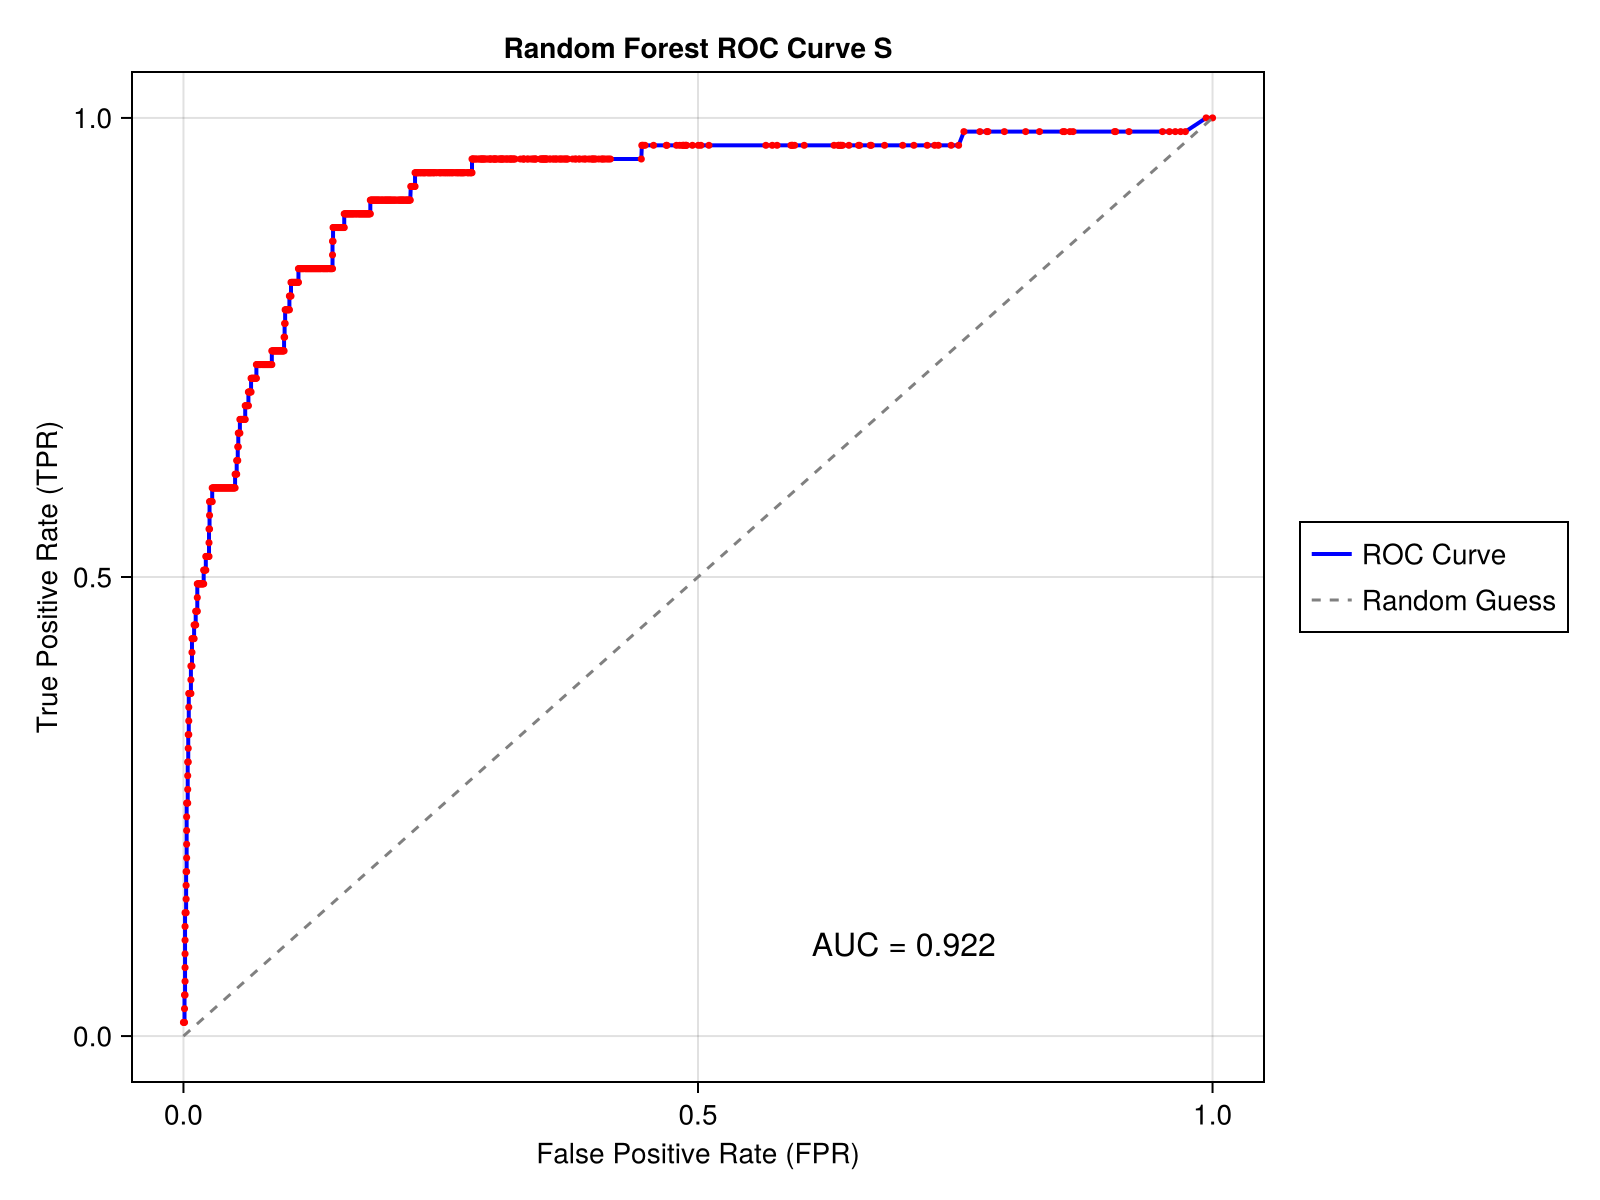

CairoMakie.Screen{IMAGE}


In [20]:
# Train Random Forest Classification Model
rf_model = DecisionTree.RandomForestClassifier(n_trees=100, max_depth=10, min_samples_split=5)
DecisionTree.fit!(rf_model, X_train, y_train)

# Predict Probabilities on the test set
pred_probs = DecisionTree.predict(rf_model, X_test)

# Threshold probabilities to get binary predictions
threshold = 0.5
predictions = pred_probs .>= threshold
y_pred = Float64.(predictions)

# Evaluate the confusion matrix
conf_matrix = compute_confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
conf_matrix_fig = plot_confusion_matrix(conf_matrix, title="Random Forest Confusion Matrix S")
display(conf_matrix_fig)

save_path = joinpath(@__DIR__, "../fig/RandomForest_CM_S.png")
save(save_path, conf_matrix_fig)  # Save as PNG

# Plot the ROC curve
fig = plot_roc_curve(y_test, pred_probs, title="Random Forest ROC Curve S")
display(fig)

save_path = joinpath(@__DIR__, "../fig/RandomForest_ROC_S.png")
save(save_path, fig)  # Save as PNG

### Balanced

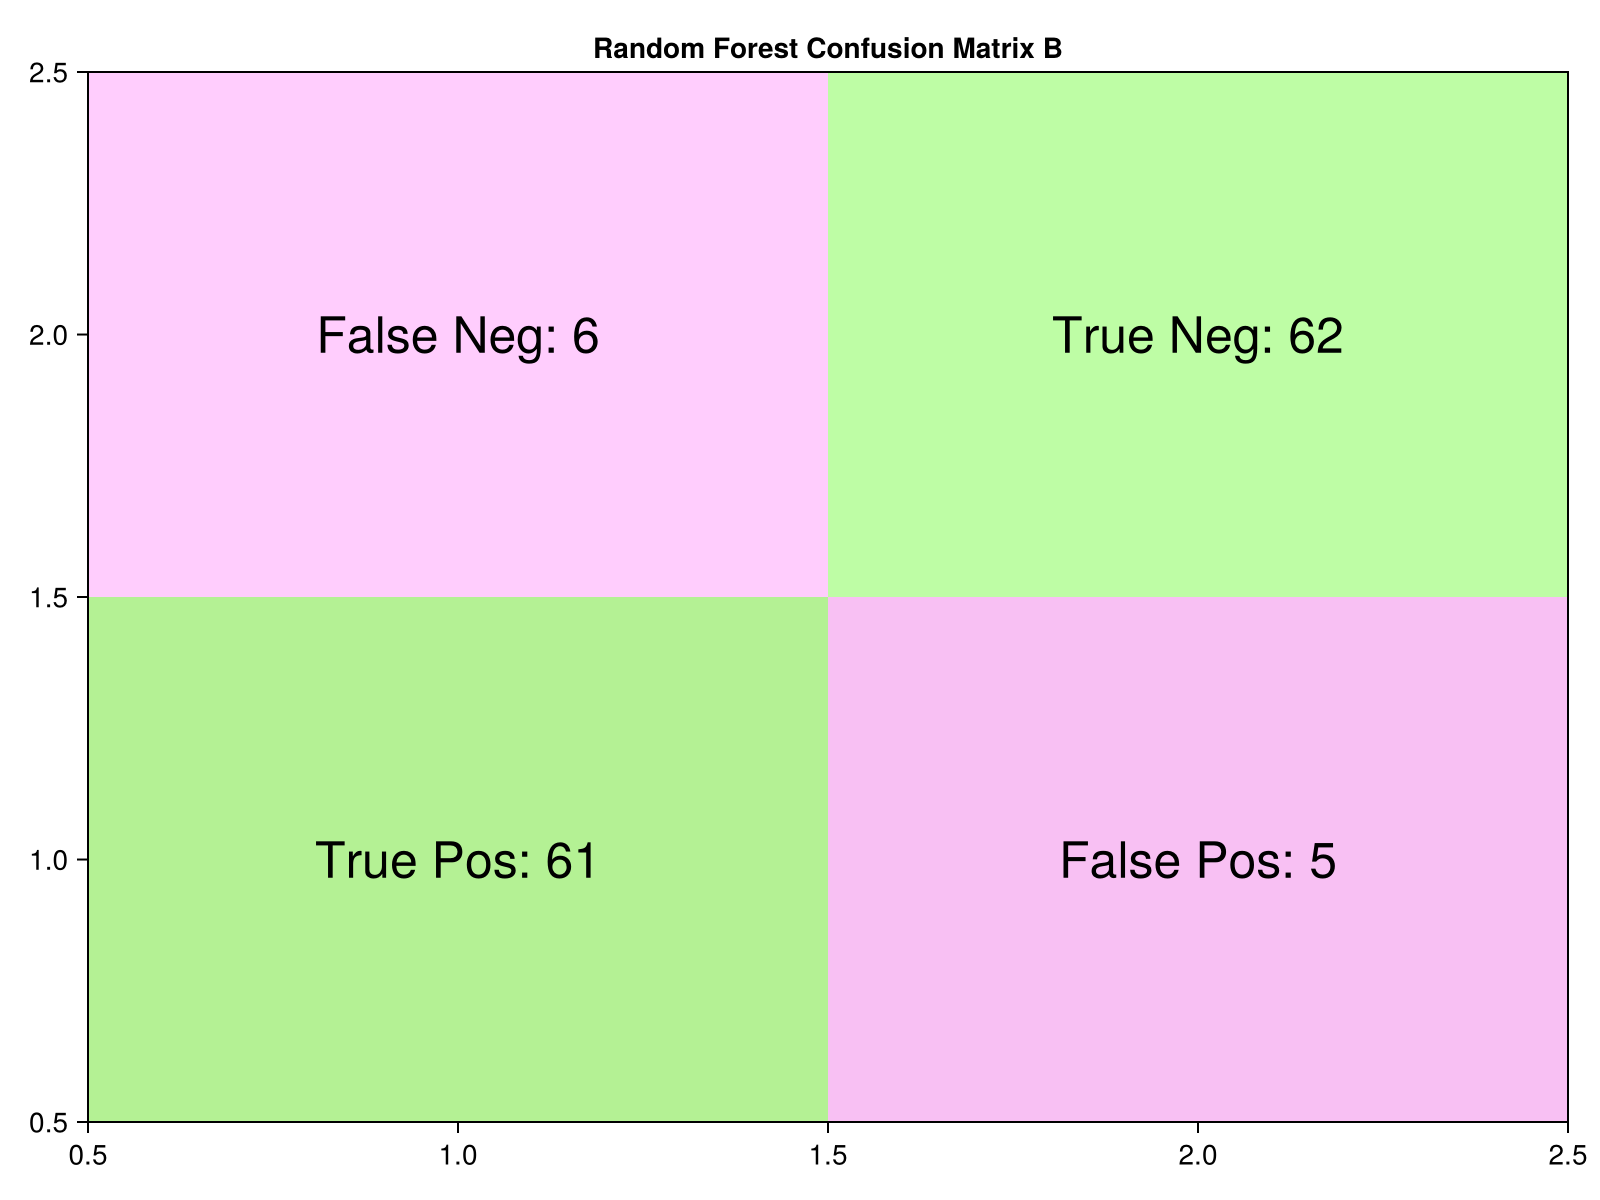

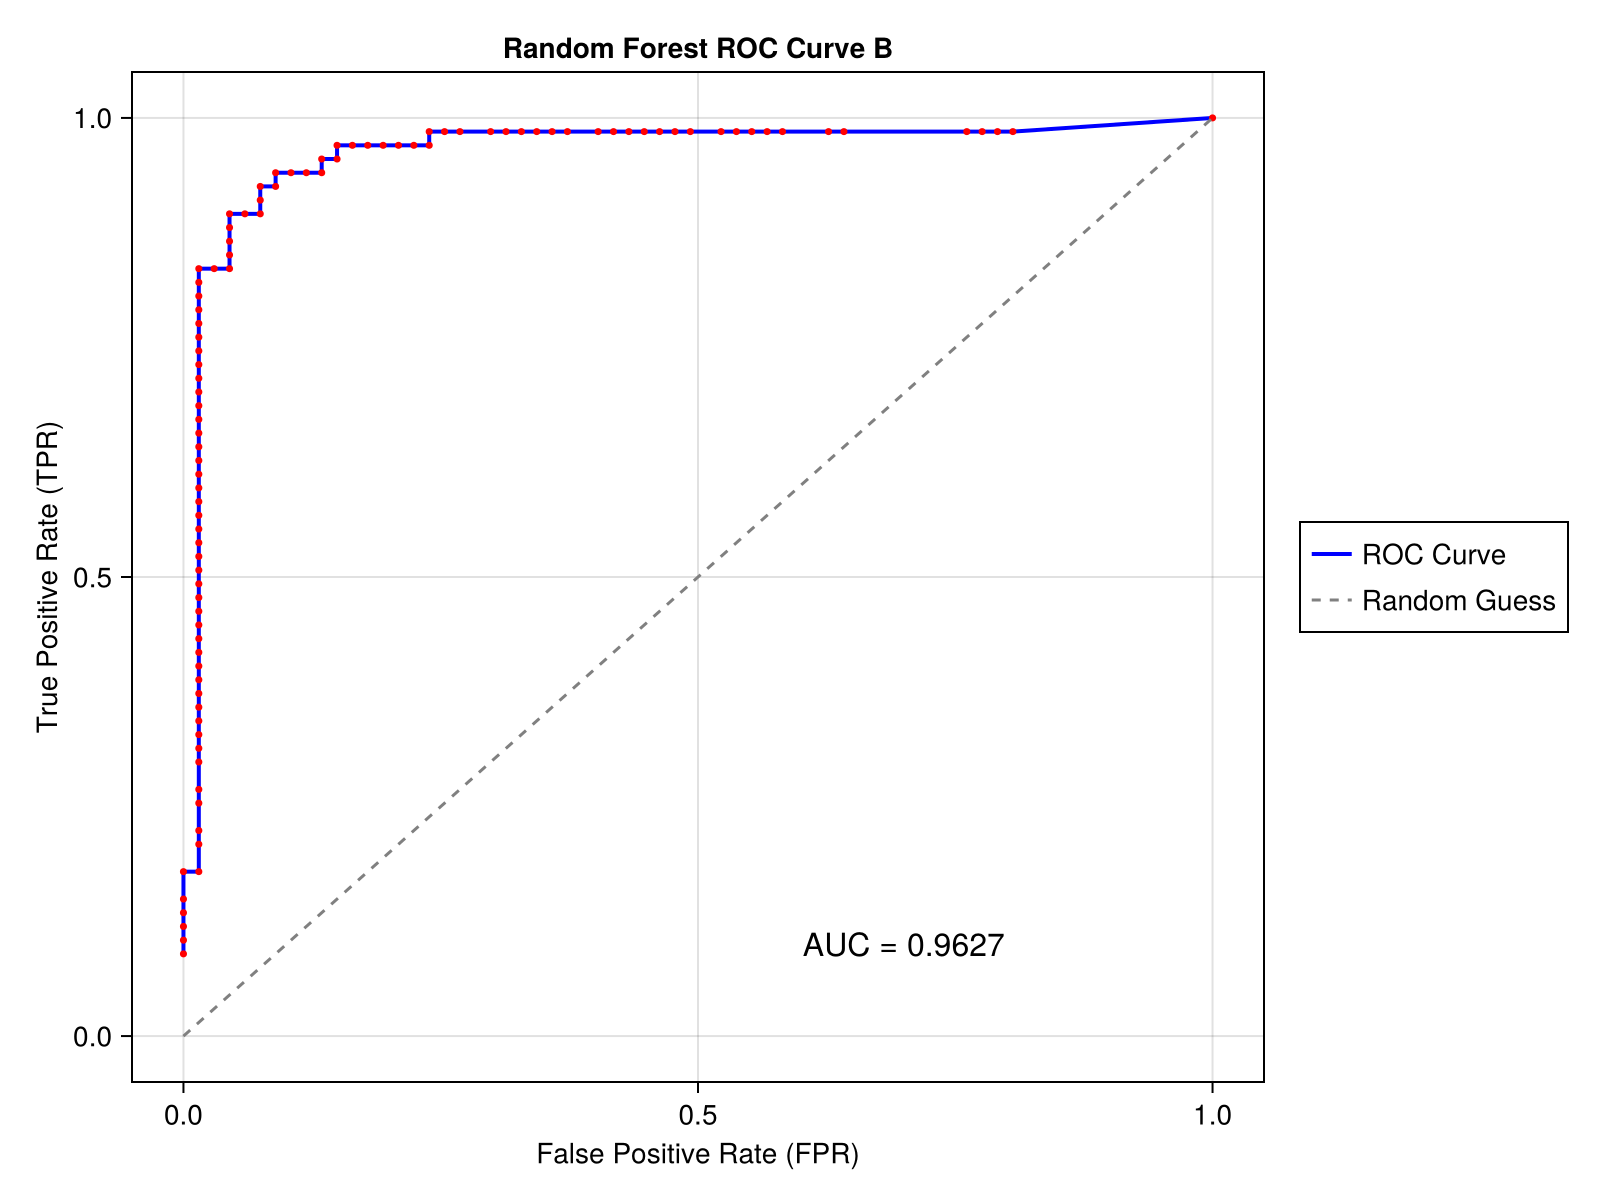

In [21]:
# Train Random Forest Classification Model
rf_model = DecisionTree.RandomForestClassifier(n_trees=100, max_depth=10, min_samples_split=5)
DecisionTree.fit!(rf_model, X_train_balanced, y_train_balanced)

# Predict Probabilities on the test set
pred_probs = DecisionTree.predict(rf_model, X_test_balanced)

# Threshold probabilities to get binary predictions
threshold = 0.5
predictions = pred_probs .>= threshold
y_pred = Float64.(predictions)

# Evaluate the confusion matrix
conf_matrix = compute_confusion_matrix(y_test_balanced, y_pred)

# Plot the confusion matrix
conf_matrix_fig = plot_confusion_matrix(conf_matrix, title="Random Forest Confusion Matrix B")
display(conf_matrix_fig)

save_path = joinpath(@__DIR__, "../fig/RandomForest_CM_B.png")
save(save_path, conf_matrix_fig)  # Save as PNG

# Plot the ROC curve
fig = plot_roc_curve(y_test_balanced, pred_probs, title="Random Forest ROC Curve B")
display(fig)

save_path = joinpath(@__DIR__, "../fig/RandomForest_ROC_B.png")
save(save_path, fig);  # Save as PNG

## Nearest Neighbors

### Stratified

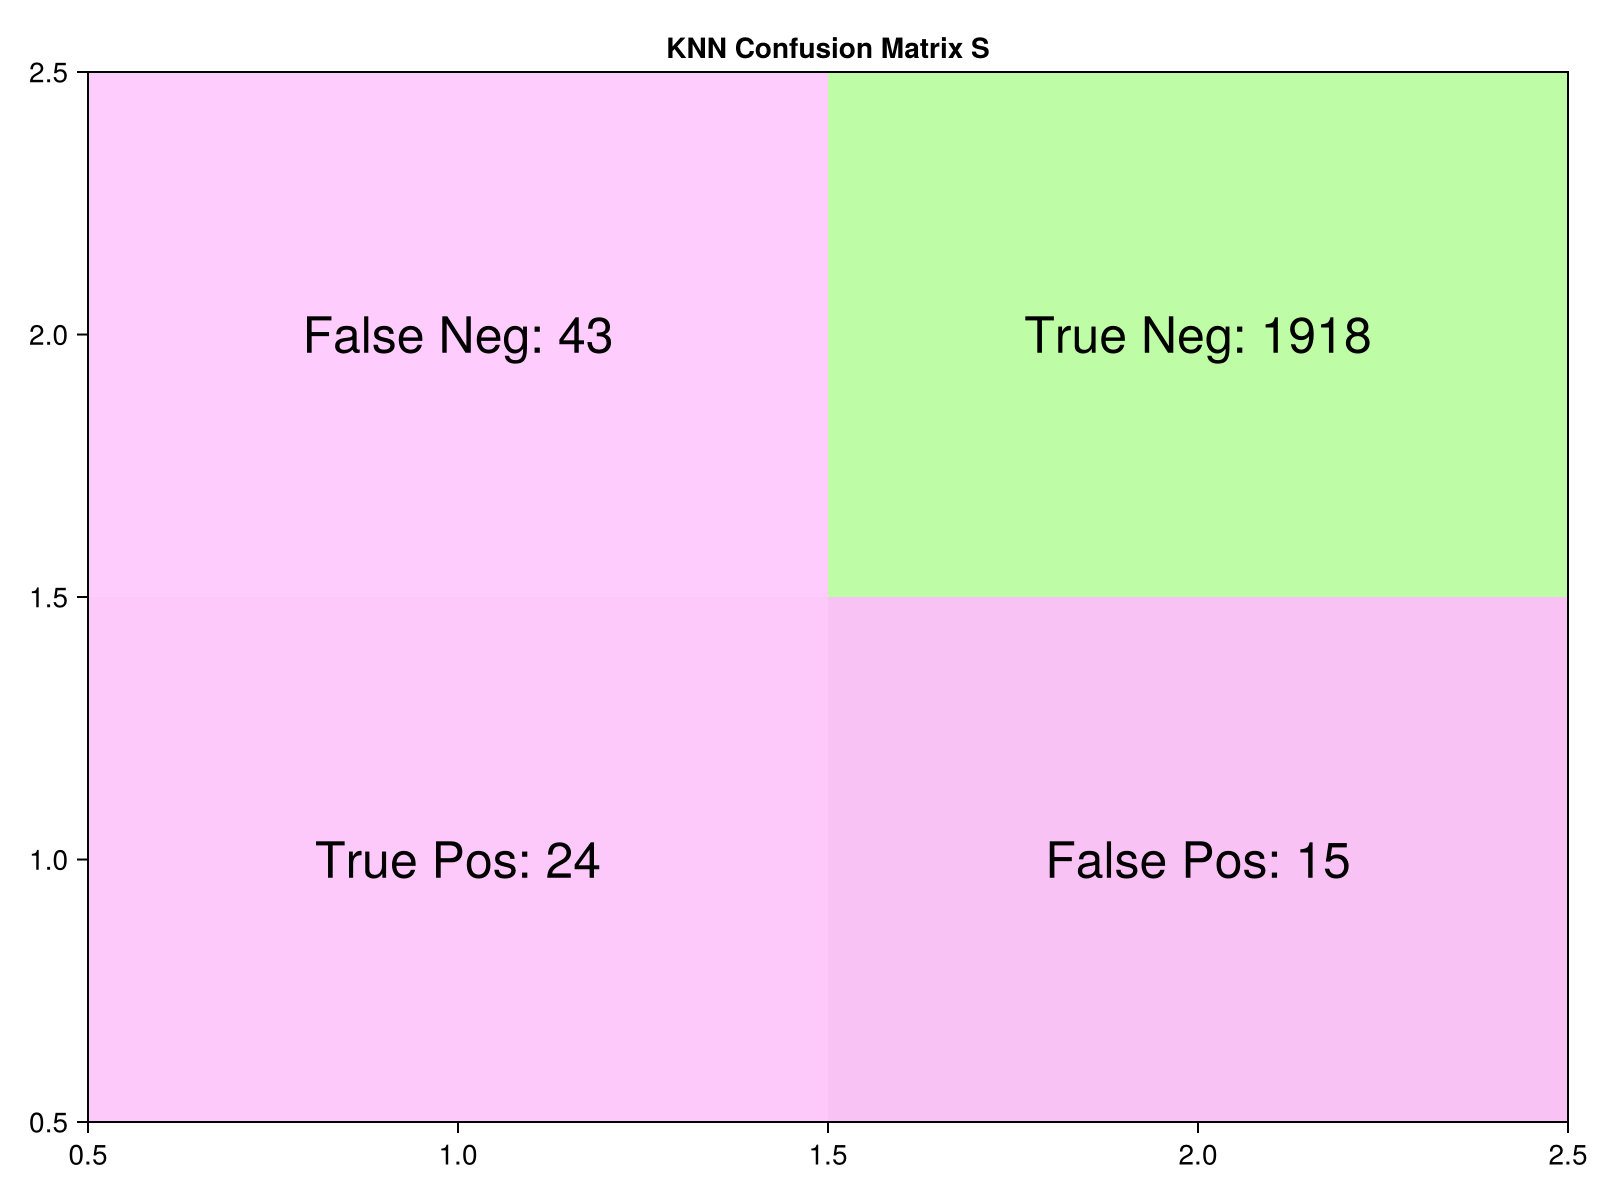

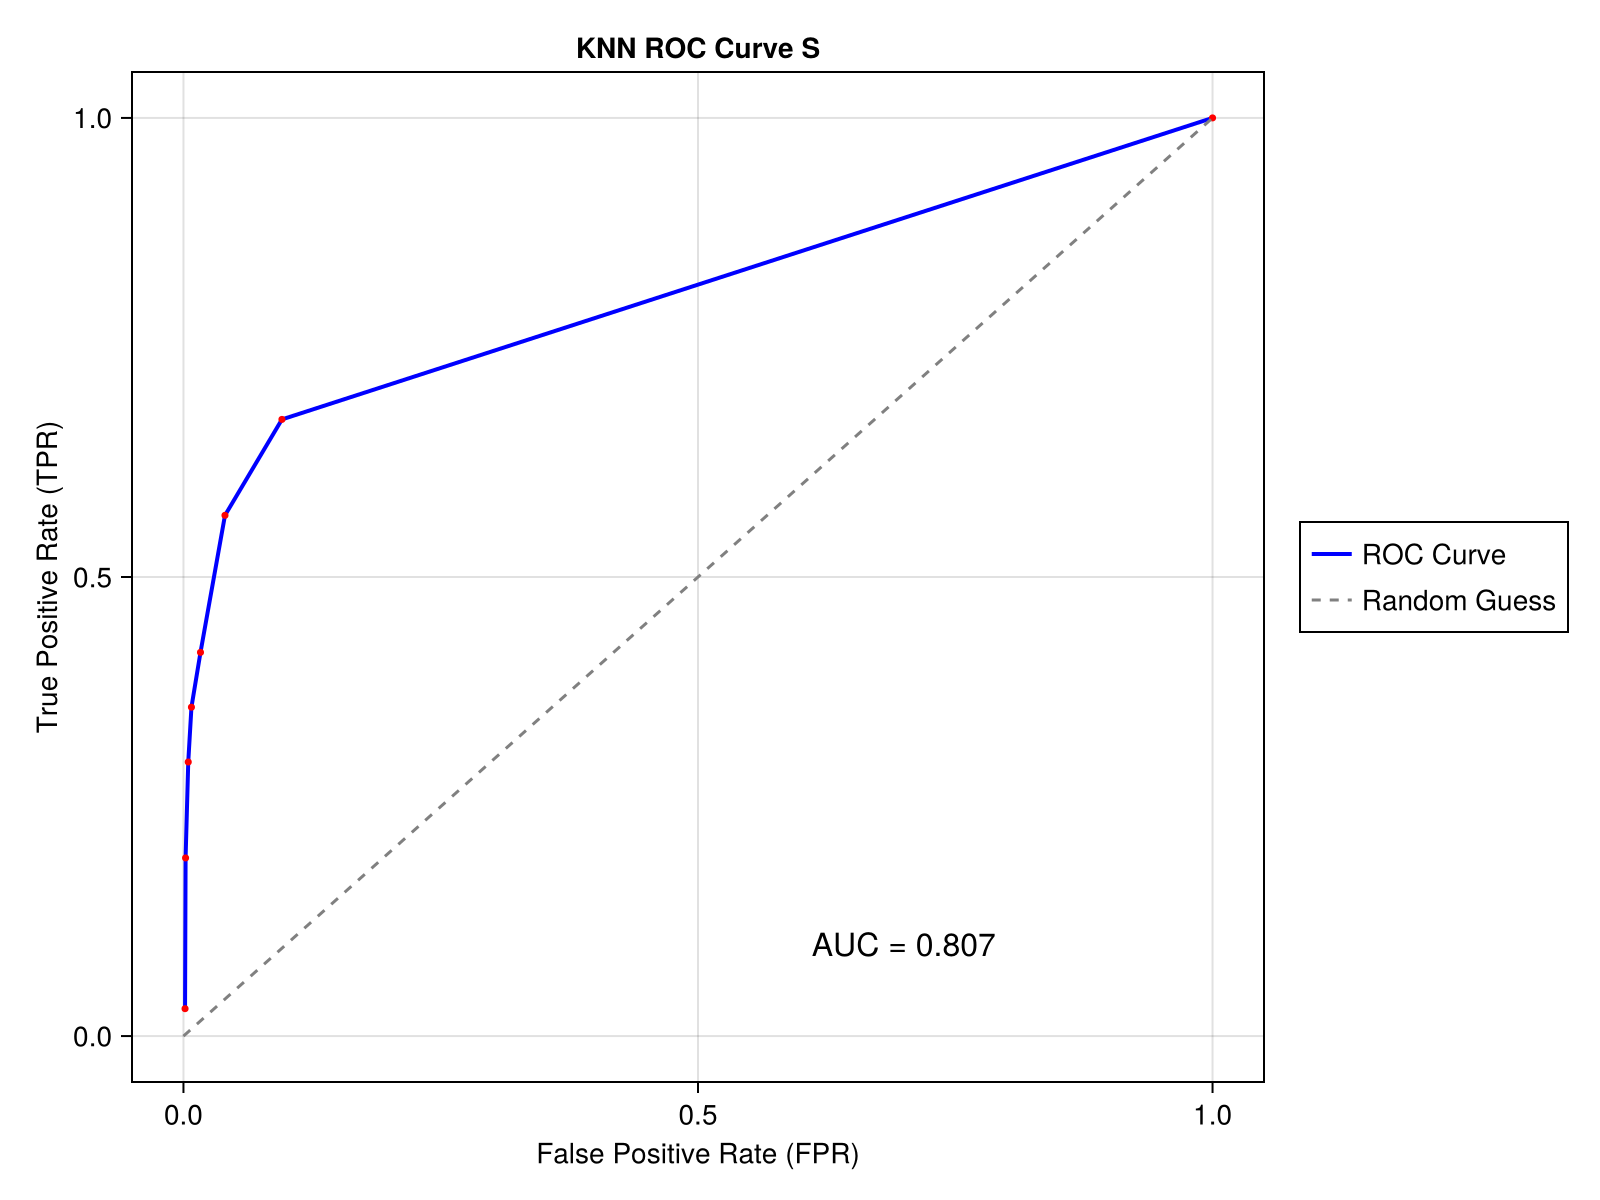

CairoMakie.Screen{IMAGE}


In [22]:
# Train Nearest Neighbors Classification Model
knn_model = NearestNeighbors.KDTree(X_train')

# Predict Probabilities on the test set
function knn_predict_proba(model, y_train, X_test, k)
    pred_probs = Float64[]
    for x in eachrow(X_test)
        indices, dists = NearestNeighbors.knn(model, collect(x), k)
        neighbor_labels = y_train[indices]
        prob = mean(neighbor_labels .== 1.0)  # Probability of positive class
        push!(pred_probs, prob)
    end
    return pred_probs
end

# Predict probabilities with k=5
pred_probs = knn_predict_proba(knn_model, y_train, X_test, 7)

# Threshold probabilities to get binary predictions
threshold = 0.5
predictions = pred_probs .>= threshold
y_pred = Float64.(predictions)

# Evaluate the confusion matrix
conf_matrix = compute_confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
conf_matrix_fig = plot_confusion_matrix(conf_matrix, title="KNN Confusion Matrix S")
display(conf_matrix_fig)

save_path = joinpath(@__DIR__, "../fig/KNN_CM_S.png")
save(save_path, conf_matrix_fig)  # Save as PNG

# Plot the ROC curve
fig = plot_roc_curve(y_test, pred_probs, title="KNN ROC Curve S")
display(fig)

save_path = joinpath(@__DIR__, "../fig/KNN_ROC_S.png")
save(save_path, fig)  # Save as PNG

### Balanced

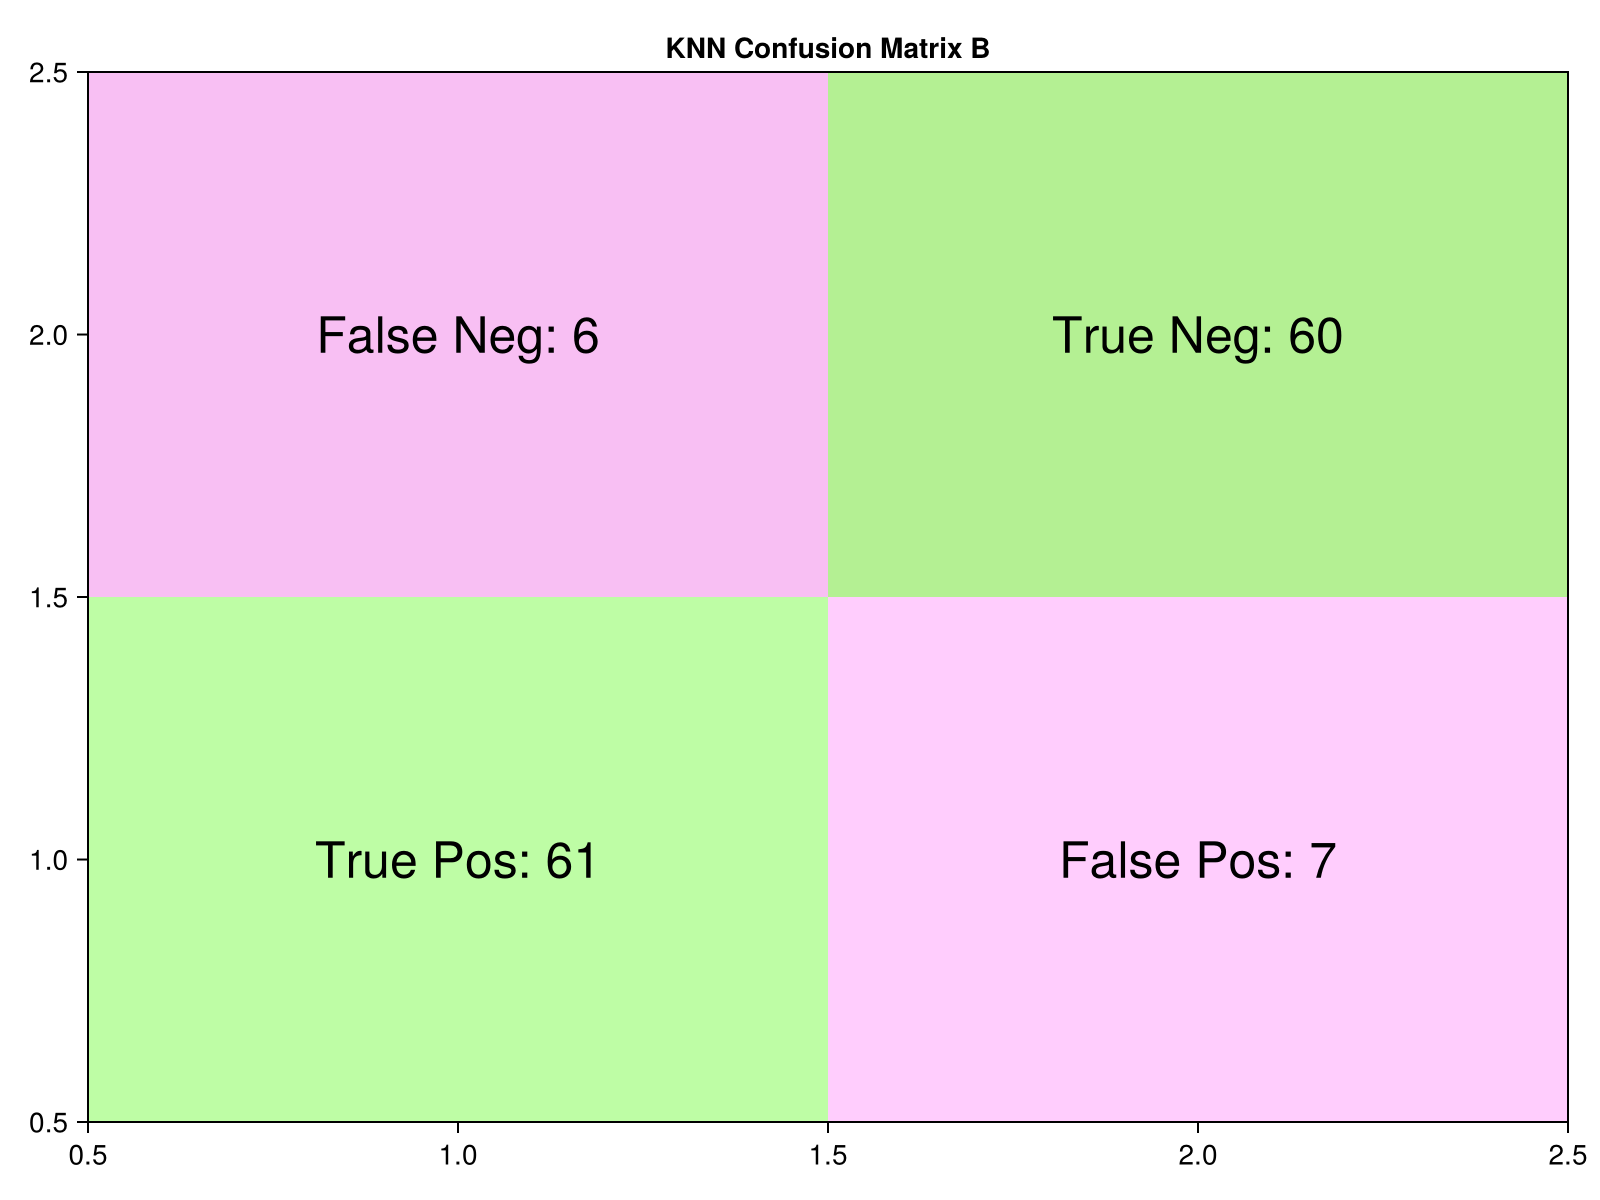

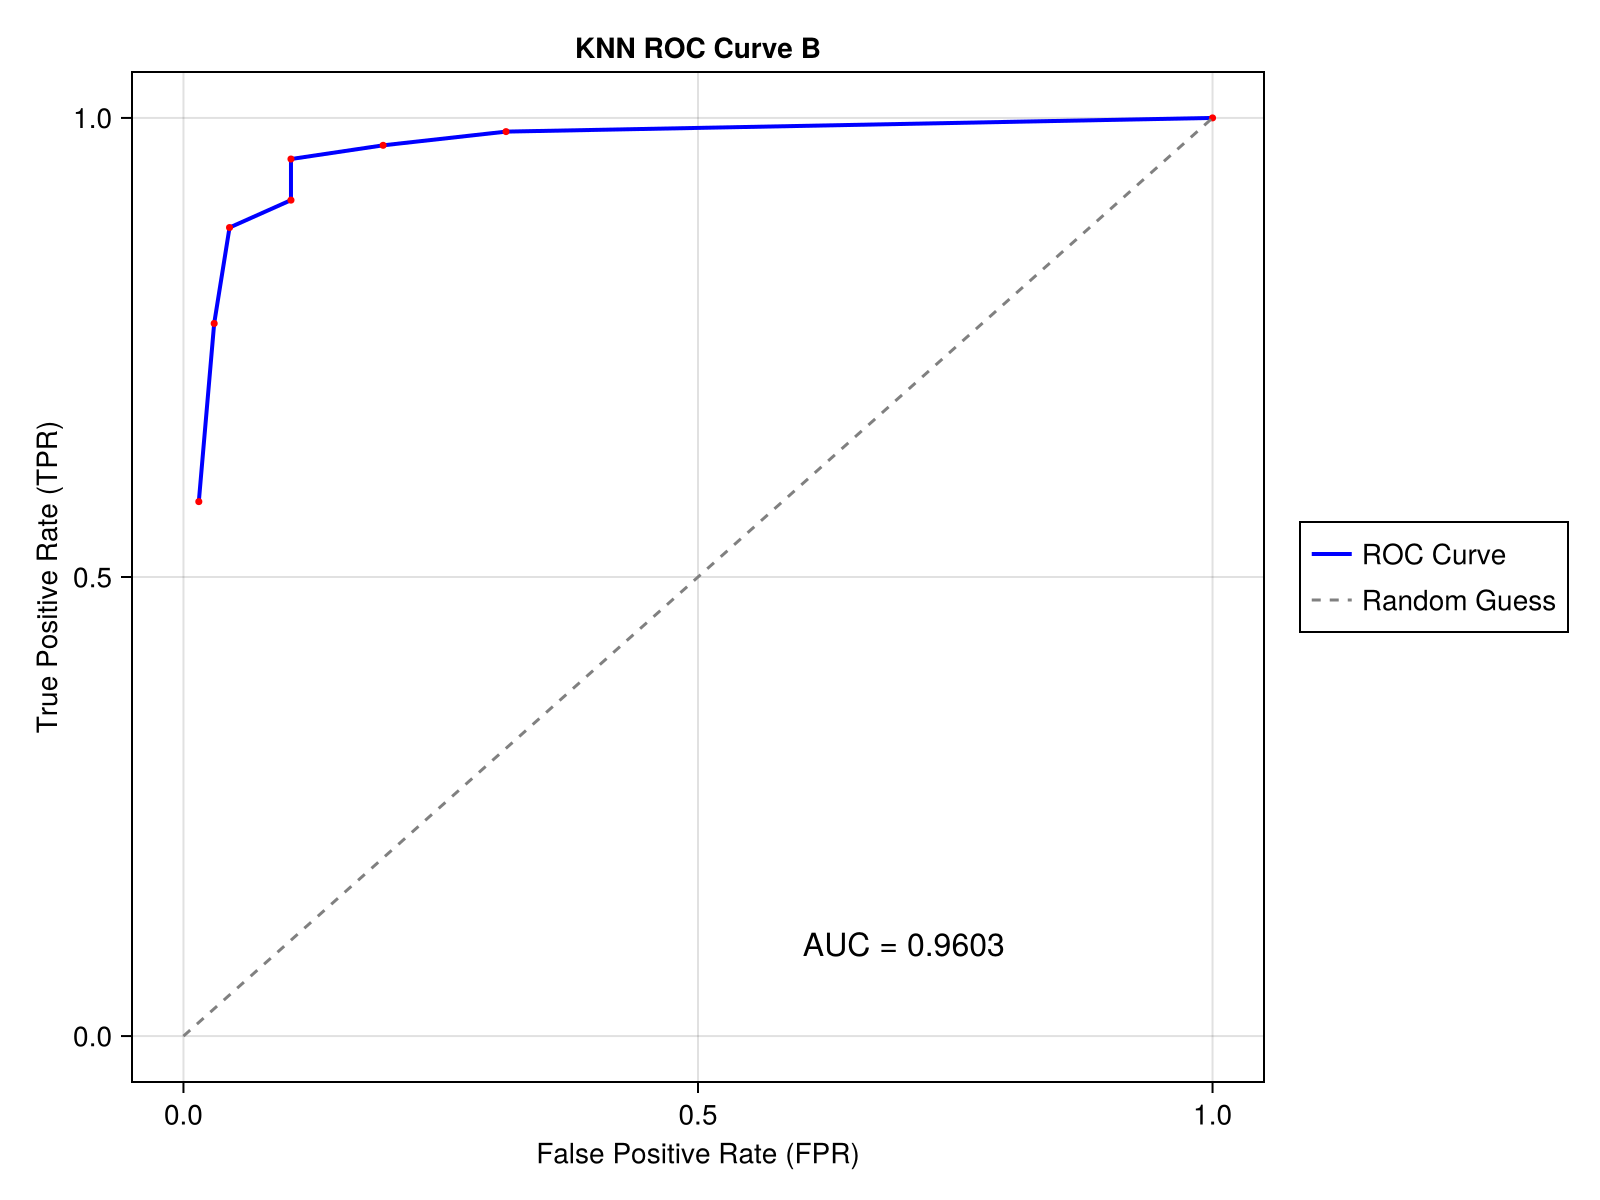

In [23]:
# Train Nearest Neighbors Classification Model
knn_model = NearestNeighbors.KDTree(X_train_balanced')

# Predict Probabilities on the test set
function knn_predict_proba(model, y_train, X_test, k)
    pred_probs = Float64[]
    for x in eachrow(X_test)
        indices, dists = NearestNeighbors.knn(model, collect(x), k)
        neighbor_labels = y_train[indices]
        prob = mean(neighbor_labels .== 1.0)  # Probability of positive class
        push!(pred_probs, prob)
    end
    return pred_probs
end

# Predict probabilities with k=5
pred_probs = knn_predict_proba(knn_model, y_train_balanced, X_test_balanced, 7)

# Threshold probabilities to get binary predictions
threshold = 0.5
predictions = pred_probs .>= threshold
y_pred = Float64.(predictions)

# Evaluate the confusion matrix
conf_matrix = compute_confusion_matrix(y_test_balanced, y_pred)

# Plot the confusion matrix
conf_matrix_fig = plot_confusion_matrix(conf_matrix, title="KNN Confusion Matrix B")
display(conf_matrix_fig)

save_path = joinpath(@__DIR__, "../fig/KNN_CM_B.png")
save(save_path, conf_matrix_fig)  # Save as PNG

# Plot the ROC curve
fig = plot_roc_curve(y_test_balanced, pred_probs, title="KNN ROC Curve B")
display(fig)

save_path = joinpath(@__DIR__, "../fig/KNN_ROC_B.png")
save(save_path, fig);  # Save as PNG

## Support Vector Machine (SVM)

### Stratified

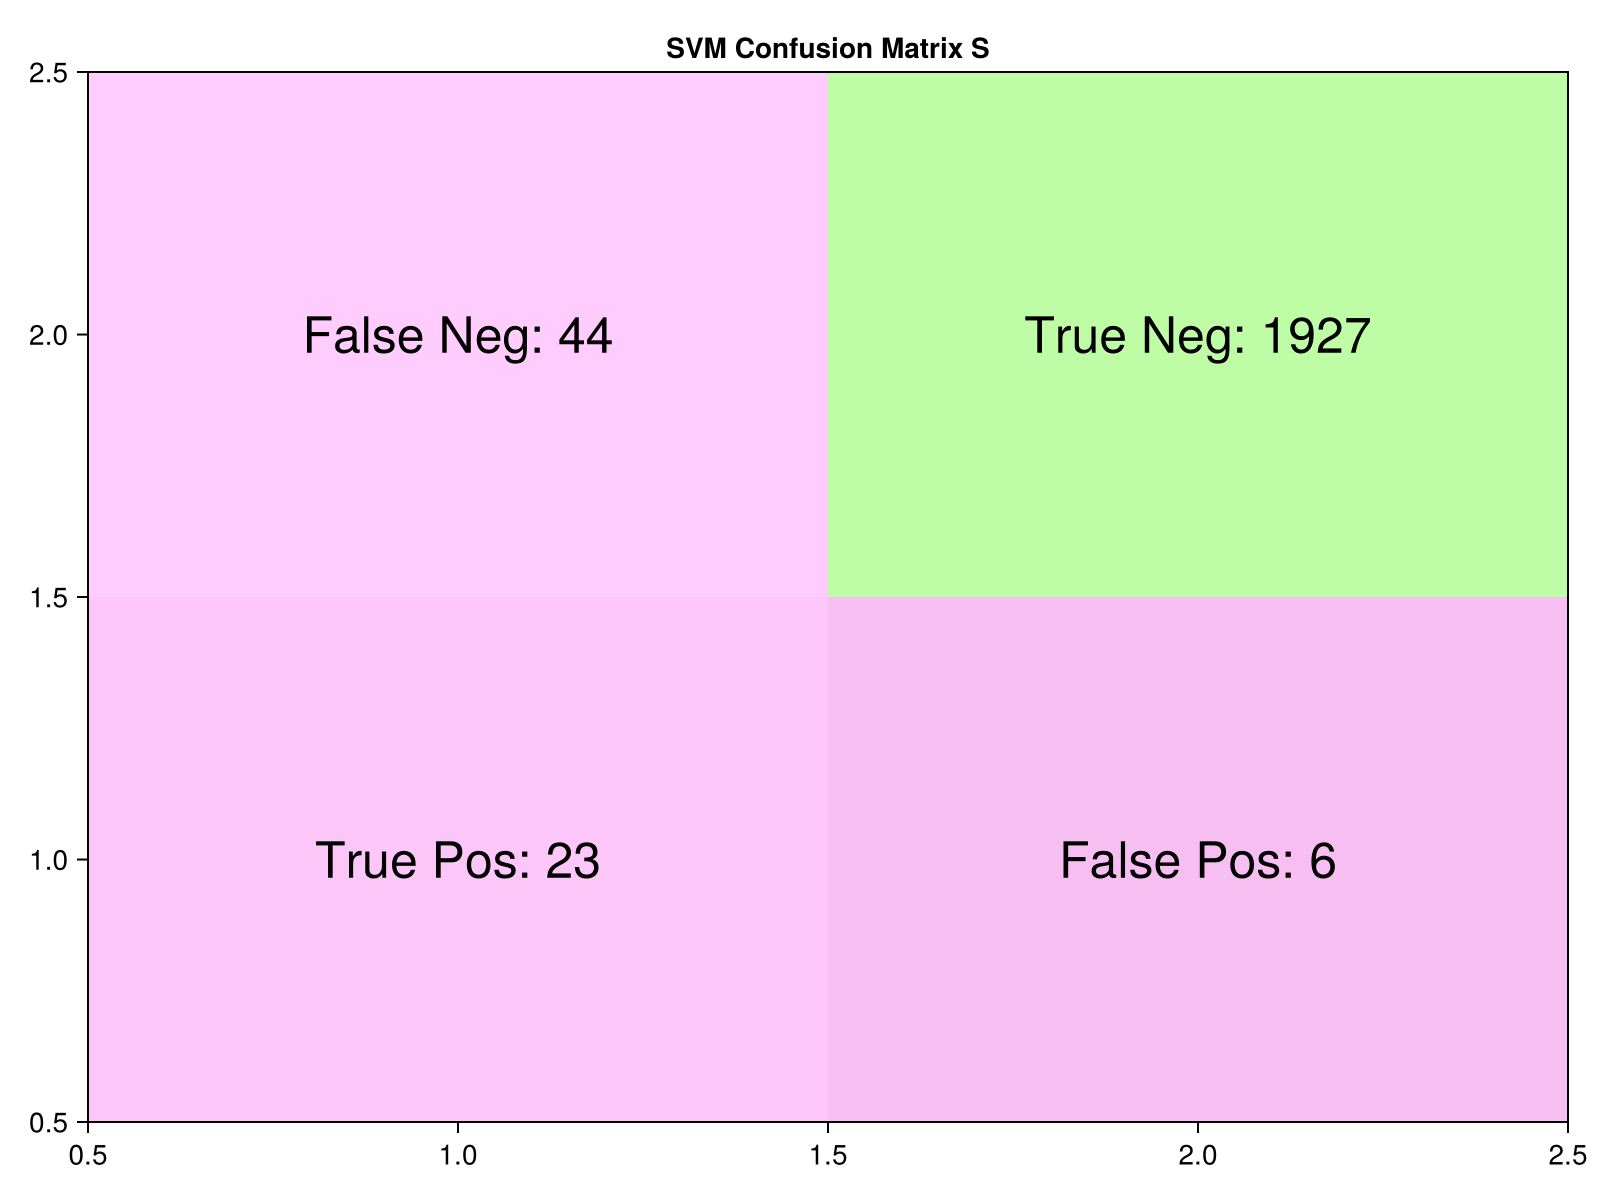

In [24]:
y_train_int = convert(Vector{Int}, y_train)

# Train Support Vector Machine Classification Model
svm_model = LIBSVM.SVC(kernel=LIBSVM.Kernel.RadialBasis, cost=1.0, probability=true)
LIBSVM.fit!(svm_model, X_train, y_train_int)

# Predict Class Labels on the Test Set
predictions = LIBSVM.predict(svm_model, X_test)  # This returns a vector of class labels
y_pred = Float64.(predictions)

# Evaluate the confusion matrix
conf_matrix = compute_confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
conf_matrix_fig = plot_confusion_matrix(conf_matrix, title="SVM Confusion Matrix S")
display(conf_matrix_fig)

save_path = joinpath(@__DIR__, "../fig/SVM_CM_S.png")
save(save_path, conf_matrix_fig);  # Save as PNG

### Balanced

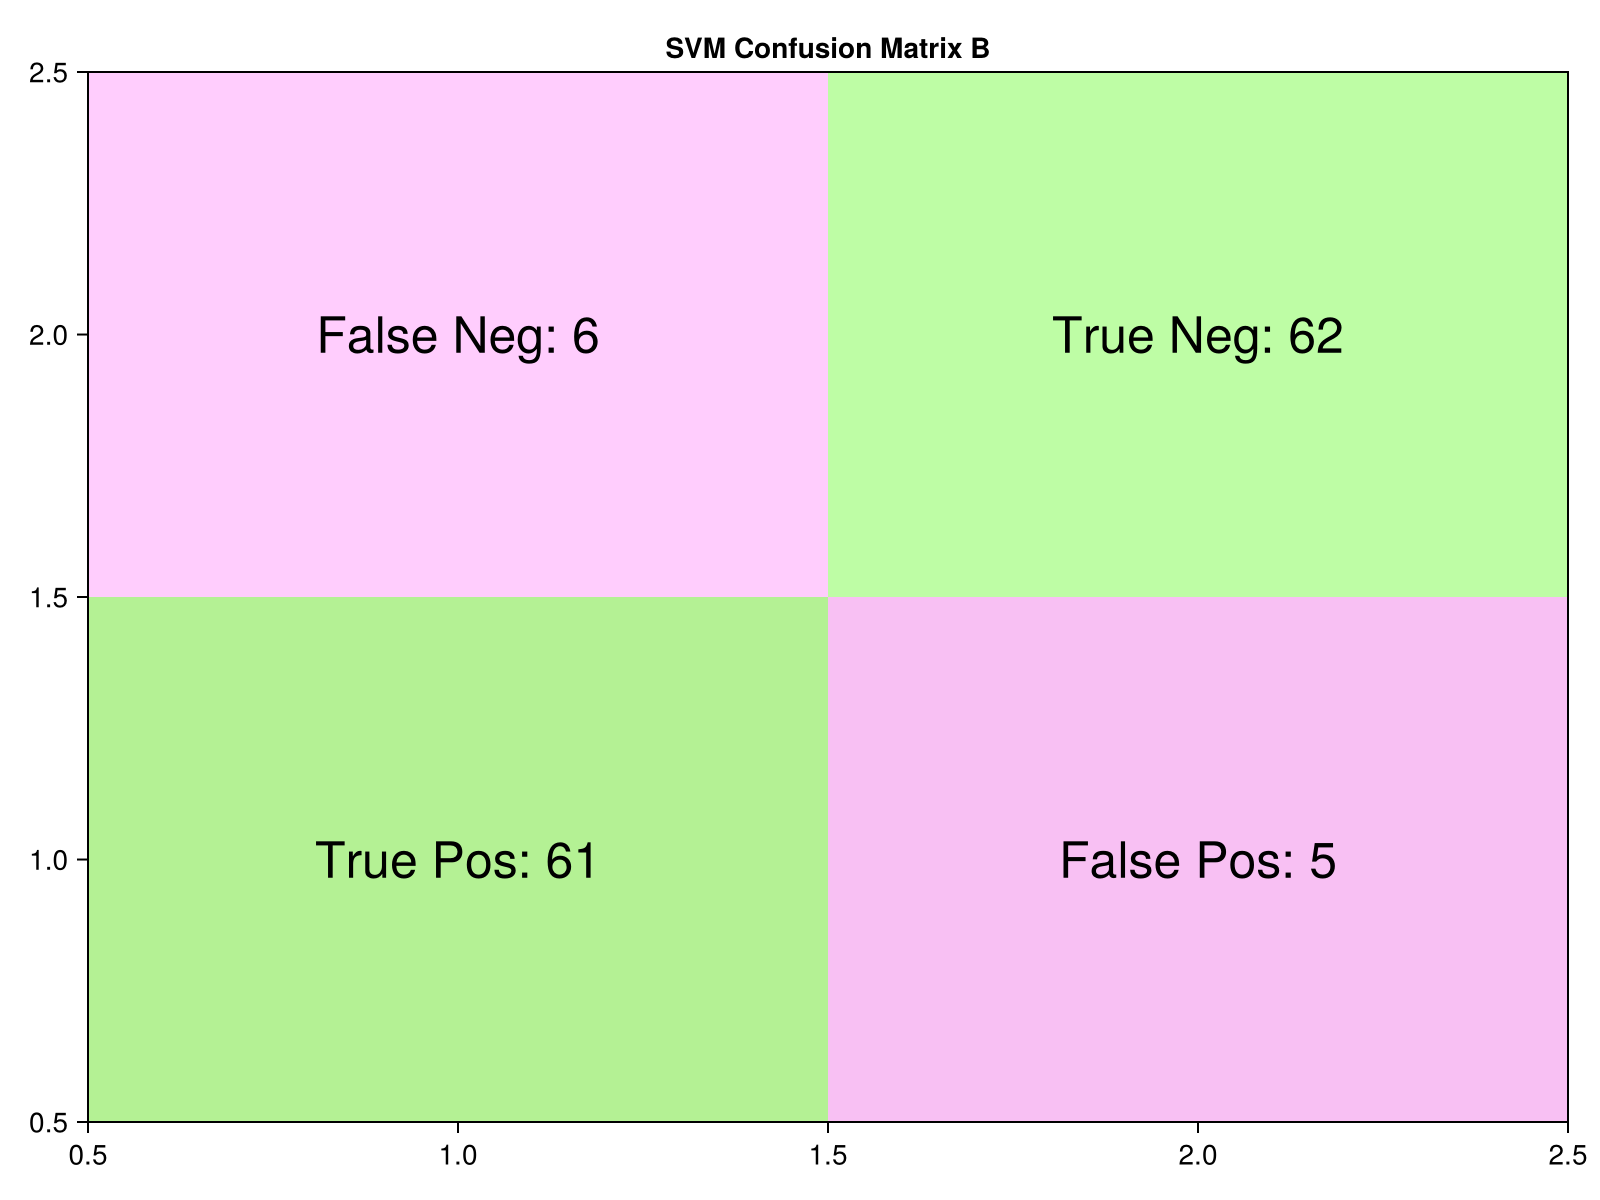

In [25]:
y_train_balanced_int = convert(Vector{Int}, y_train_balanced)

# Train Support Vector Machine Classification Model
svm_model = LIBSVM.SVC(kernel=LIBSVM.Kernel.RadialBasis, cost=1.0)
LIBSVM.fit!(svm_model, X_train_balanced, y_train_balanced_int)

# Predict Class Labels on the Test Set
predictions = LIBSVM.predict(svm_model, X_test_balanced)  # This returns a vector of class labels
y_pred = Float64.(predictions)

# Evaluate the confusion matrix
conf_matrix = compute_confusion_matrix(y_test_balanced, y_pred)

# Plot the confusion matrix
conf_matrix_fig = plot_confusion_matrix(conf_matrix, title="SVM Confusion Matrix B")
display(conf_matrix_fig)

save_path = joinpath(@__DIR__, "../fig/SVM_CM_B.png")
save(save_path, conf_matrix_fig);  # Save as PNG
